# GitHub page
* https://github.com/junqilu/AntiSARSCoV2Prediction  


# In silico prediction for potential non-phospholipidosis-inducing inhibitors against in vitro replication of SARS-CoV-2


## Authors: Junqi Lu, Anish Karpurapu

> COVID-19 has been a major public health threat worldwide for almost two years now. Although the antibodies and vaccines against SARS-CoV-2 had been developed, the current options for small-molecule drugs are still extremely limited regardless of their indispensable advantages. 

> Our project aims to develop two models, AntiCovid and AntiPhospho, to screen out the molecules that can be effective against SARS-CoV-2 and the molecules that do not induce phospholipidosis, respectively.  Combinging the two models, we aim to screen out non-phospholipidosis-inducing modlecules that can be further tested and developed into anti-COVID-19 drugs. 


# Packages install and import chunk below

In [ ]:
!pip install rdkit-pypi 
!pip install --pre deepchem 
!pip install biokit 
!pip install pickle5 
!pip install collinearity
!pip install scikit-learn-extra

     |████████████████████████████████| 20.6 MB 80.1 MB/s 
     |████████████████████████████████| 608 kB 5.2 MB/s 
     |████████████████████████████████| 162 kB 5.1 MB/s 
     |████████████████████████████████| 47 kB 3.9 MB/s 
     |████████████████████████████████| 202 kB 49.6 MB/s 
     |████████████████████████████████| 2.3 MB 39.9 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 44 kB 1.9 MB/s 
     |████████████████████████████████| 144 kB 64.7 MB/s 
     |████████████████████████████████| 5.8 MB 39.7 MB/s 
     |████████████████████████████████| 251 kB 62.9 MB/s 
     |████████████████████████████████| 127 kB 39.2 MB/s 
  Created wheel for biokit: filename=biokit-0.5.0-py3-none-any.whl size=177149 sha256=5ef00e09714589366bb9b550b09d6768f298aedb1e6e6657a8340e39fad18c4b
  Stored in directory: /root/.cache/pip/wheels/2f/30/fe/0a5e0df22f6ac201067237923fbad60309bb6f7dc68ff6b346
  Created wheel for bioservices: filename=bioservices

In [ ]:
%%capture 
#run the cell, capturing stdout, stderr, and IPython’s rich display() calls

#Basics
import numpy as np
import pandas as pd #Basic dataframe package

#Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
from biokit.viz import corrplot #For checking correlations between descriptors


#Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, MACCSkeys, AllChem, Draw #Generate a dataframe of descriptors from SMILES
import deepchem as dc

#Data preprocessing 
# import imblearn #For imbalanced data. Use class weight first before you throw out data or generate artificial data 
from sklearn.model_selection import train_test_split #For the hold-out method 
from sklearn.preprocessing import StandardScaler #For scaling, which is reuiqred by SVM
from sklearn.feature_selection import VarianceThreshold #For checking descriptors with low variance 
from collinearity import SelectNonCollinear #For throw out highly correlated variables
from sklearn.decomposition import PCA #For feature engineering 
from sklearn.manifold import TSNE

#Models
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split  #For cross-validation
from sklearn.model_selection import StratifiedKFold #For stratified cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold #For repeated stratified cross-validation
from sklearn.model_selection import GridSearchCV #For hyperparameter tuning
from sklearn.model_selection import ParameterGrid #For hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier #For GBM 
from sklearn.ensemble import StackingClassifier #For ensemble learning, specifically in a stacking style. If you want the voting style, you can use VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import clone #Use to duplicate a model. This is necessary since best_estimator_.set_params(**temp_model_params) will change all unless you make a clone. Once you have a clone, you still need to train it by fit()

#For saving the intermediate files for later uses 
import pickle5 as pickle #Must use pickle5 for Google colab since it uses a Python version 3.6. In Python 3.8, you can replace this line by simply import pickle 
import cloudpickle as cp
from urllib.request import urlopen

#Evaluations
from sklearn.metrics import make_scorer #This makes scorer to be used as part of the scoring parameter for GridSearchCV
from sklearn.metrics import matthews_corrcoef #MCC
from sklearn.metrics import recall_score #Recall
from sklearn.metrics import roc_auc_score #AUC
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, balanced_accuracy_score
from sklearn.utils import shuffle #For shuffle up the dataset

# Self-defined functions
* For dump and load pickles

In [ ]:
def dump_pickle(content_to_dump, pickle_name_str): #Dump the content_to_dump into a pickle. Remember to include ".pkl" in pickle_name_str
  cp.dump(content_to_dump, open(pickle_name_str, 'wb')) #Save the GridSearchCV object to be used later
  return

def load_cloud_pickle(github_url): #Load pickles (contain trained models) from a GitHub link
  url_raw_file=github_url+'?raw=true'
  loaded_pickle_object = pickle.load(urlopen(url_raw_file)) 
  return loaded_pickle_object

# AntiCovid
* To avoid conflict on variable names, all the variables used in this section will have a suffix "i" for inhibitor.

## Imbalanced original dataset


### Data preprocessing

#### Load data 

In [ ]:
df_inhb = pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/AntiVirusPrediction/RawData/inhibition.csv?raw=true')
df_inhb = df_inhb[['Molecule ChEMBL ID', 'Smiles', 'Standard Value']]
df_inhb.dropna(inplace=True)
PandasTools.AddMoleculeColumnToFrame(df_inhb,'Smiles','molecule')
df_inhb.reset_index(inplace=True)
df_inhb['test'] = np.where(df_inhb['Standard Value']> 75, 1, 0)

#### Adding molecular descriptors

In [ ]:
#RDKIT DESCRIPTORS
simpleList = [x[0] for x in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(simpleList)
descriptors_list = [calculator.CalcDescriptors(smile) for smile in df_inhb['molecule']]
df_descriptor = pd.DataFrame(descriptors_list, columns=range(0,len(descriptors_list[0])))
df_rdkit_i = pd.merge(df_inhb, df_descriptor, left_index=True, right_index=True)
df_rdkit_i.dropna(inplace=True)
df_rdkit_i.reset_index(inplace=True)

#MORGAN FINGERPRINT DESCRIPTORS
morgan_list = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024).ToBitString() for m in df_inhb['molecule']]
morgan_np = np.array([list(x) for x in morgan_list], dtype='int')
df_morgan = pd.DataFrame(morgan_np)
df_morgan_i = pd.merge(df_inhb, df_morgan, left_index=True, right_index=True)
df_morgan_i.dropna(inplace=True)
df_morgan_i.reset_index(inplace=True)

#MACCS KEYS DESCRIPTORS
maccs_list = [MACCSkeys.GenMACCSKeys(m) for m in df_inhb['molecule']]
maccs_np = np.array([list(x) for x in maccs_list], dtype='int')
df_maccs = pd.DataFrame(maccs_np)
df_maccs_i = pd.merge(df_inhb, df_maccs, left_index=True, right_index=True)
df_maccs_i.dropna(inplace=True)
df_maccs_i.reset_index(inplace=True)

#### Train Test Split

In [ ]:
#RDKIT
X_rd_i = df_rdkit_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_rd_i = df_rdkit_i['test']
X_train_rd_i, X_test_rd_i, y_train_rd_i, y_test_rd_i = train_test_split(X_rd_i,y_rd_i,test_size=0.2, random_state=0, stratify=y_rd_i)

scaler= MinMaxScaler()
X_train_rd_i = scaler.fit_transform(X_train_rd_i)
X_test_rd_i = scaler.transform(X_test_rd_i)

#MORGAN
X_mo_i = df_morgan_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_mo_i = df_morgan_i['test']
X_train_mo_i, X_test_mo_i, y_train_mo_i, y_test_mo_i = train_test_split(X_mo_i,y_mo_i,test_size=0.2, random_state=0, stratify=y_mo_i)

scaler= MinMaxScaler()
X_train_mo_i = scaler.fit_transform(X_train_mo_i)
X_test_mo_i = scaler.transform(X_test_mo_i)

#MACCS
X_ma_i = df_maccs_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_ma_i = df_maccs_i['test']
X_train_ma_i, X_test_ma_i, y_train_ma_i, y_test_ma_i = train_test_split(X_ma_i,y_ma_i,test_size=0.2, random_state=0, stratify=y_ma_i)

scaler= MinMaxScaler()
X_train_ma_i = scaler.fit_transform(X_train_ma_i)
X_test_ma_i = scaler.transform(X_test_ma_i)

#### Exploratory Data Analysis - tSNEs
* tSNEs on RDKit descriptors, Morgan fingerprint, and MACCS keys

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


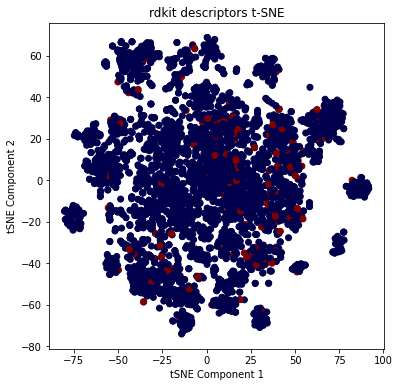

In [ ]:
pca = PCA(n_components=50)
pca.fit(X_train_rd_i)

pca_50 = pca.fit_transform(X_train_rd_i)

tsne = TSNE(n_components=2, random_state=0).fit_transform(pca_50)

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(tsne[:,0], tsne[:,1], c=y_train_rd_i, cmap='seismic')
#ax1.legend()
ax.set_xlabel('tSNE Component 1')
ax.set_ylabel('tSNE Component 2')
ax.set_title('rdkit descriptors t-SNE')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


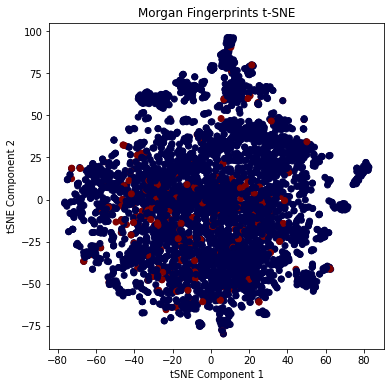

In [ ]:
pca = PCA(n_components=50)
pca.fit(X_train_mo_i)

pca_50 = pca.fit_transform(X_train_mo_i)

tsne = TSNE(n_components=2, random_state=0).fit_transform(pca_50)

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(tsne[:,0], tsne[:,1], c=y_train_mo_i, cmap='seismic')
#ax1.legend()
ax.set_xlabel('tSNE Component 1')
ax.set_ylabel('tSNE Component 2')
ax.set_title('Morgan Fingerprints t-SNE')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


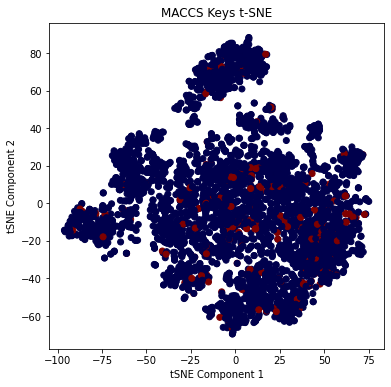

In [ ]:
pca = PCA(n_components=50)
pca.fit(X_train_ma_i)

pca_50 = pca.fit_transform(X_train_ma_i)

tsne = TSNE(n_components=2, random_state=0).fit_transform(pca_50)

fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(tsne[:,0], tsne[:,1], c=y_train_ma_i, cmap='seismic')
#ax1.legend()
ax.set_xlabel('tSNE Component 1')
ax.set_ylabel('tSNE Component 2')
ax.set_title('MACCS Keys t-SNE')
plt.show()

#### Try baseline models for each of the molecular descriptors

In [ ]:
from sklearn.model_selection import StratifiedKFold
X = X_train_rd_i
y = y_train_rd_i.ravel()
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

accuracies = []
f1 = []
precisions = []
recalls = []
balanced_accuracy_scores = []
bedrocs = []
aucs = []
for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  rf = RandomForestClassifier(n_estimators=200, random_state=0, class_weight="balanced")
  rf.fit(X_train,y_train)

  y_pred = rf.predict(X_test)
  accuracies.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred))
  recalls.append(recall_score(y_test, y_pred))
  balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
  
  metric = dc.metrics.roc_auc_score
  aucs.append(metric(y_test, y_pred))

  y_pred_i = rf.predict_proba(X_test)
  metric = dc.metrics.bedroc_score
  bedrocs.append(metric(y_test, y_pred_i))
  
print("Avg Accuracy:",np.mean(accuracies))
print("Avg F1:",np.mean(f1))
print("Avg Precision:",np.mean(precisions))
print("Avg Recall:",np.mean(recalls))
print("Avg Balanced Accuracy:",np.mean(balanced_accuracy_scores))
print("Avg Bedroc:",np.mean(bedrocs))
print("Avg AUC:",np.mean(aucs))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

Avg Accuracy: 0.9505529953917049
Avg F1: 0.017786561264822136
Avg Precision: 0.2
Avg Recall: 0.009307359307359308
Avg Balanced Accuracy: 0.504532614278377
Avg Bedroc: 0.3089546912755955
Avg AUC: 0.504532614278377


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X = X_train_mo_i
y = y_train_mo_i.ravel()
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

accuracies = []
f1 = []
precisions = []
recalls = []
balanced_accuracy_scores = []
bedrocs = []
aucs = []
for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  rf = RandomForestClassifier(n_estimators=200, random_state=0, class_weight="balanced")
  rf.fit(X_train,y_train)

  y_pred = rf.predict(X_test)
  accuracies.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred))
  recalls.append(recall_score(y_test, y_pred))
  balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
  
  metric = dc.metrics.roc_auc_score
  aucs.append(metric(y_test, y_pred))

  y_pred_i = rf.predict_proba(X_test)
  metric = dc.metrics.bedroc_score
  bedrocs.append(metric(y_test, y_pred_i))
  
print("Avg Accuracy:",np.mean(accuracies))
print("Avg F1:",np.mean(f1))
print("Avg Precision:",np.mean(precisions))
print("Avg Recall:",np.mean(recalls))
print("Avg Balanced Accuracy:",np.mean(balanced_accuracy_scores))
print("Avg Bedroc:",np.mean(bedrocs))
print("Avg AUC:",np.mean(aucs))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Avg Accuracy: 0.9519220397890699
Avg F1: 0.05769565217391306
Avg Precision: 0.35
Avg Recall: 0.031818181818181815
Avg Balanced Accuracy: 0.5153214079485828
Avg Bedroc: 0.36529299888980843
Avg AUC: 0.5153214079485828


In [ ]:
X = X_train_ma_i
y = y_train_ma_i.ravel()
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

accuracies = []
f1 = []
precisions = []
recalls = []
balanced_accuracy_scores = []
bedrocs = []
aucs = []
for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  rf = RandomForestClassifier(n_estimators=200, random_state=0, class_weight="balanced")
  rf.fit(X_train,y_train)

  y_pred = rf.predict(X_test)
  accuracies.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred))
  recalls.append(recall_score(y_test, y_pred))
  balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
  
  metric = dc.metrics.roc_auc_score
  aucs.append(metric(y_test, y_pred))

  y_pred_i = rf.predict_proba(X_test)
  metric = dc.metrics.bedroc_score
  bedrocs.append(metric(y_test, y_pred_i))
  
print("Avg Accuracy:",np.mean(accuracies))
print("Avg F1:",np.mean(f1))
print("Avg Precision:",np.mean(precisions))
print("Avg Recall:",np.mean(recalls))
print("Avg Balanced Accuracy:",np.mean(balanced_accuracy_scores))
print("Avg Bedroc:",np.mean(bedrocs))
print("Avg AUC:",np.mean(aucs))

Avg Accuracy: 0.9499101150527325
Avg F1: 0.05800000000000001
Avg Precision: 0.31666666666666665
Avg Recall: 0.03203463203463204
Avg Balanced Accuracy: 0.5143724665282247
Avg Bedroc: 0.3075893977869473
Avg AUC: 0.5143724665282245


#### Results for baseline random forests with molecular descriptor sets

<Figure size 640x1200 with 0 Axes>

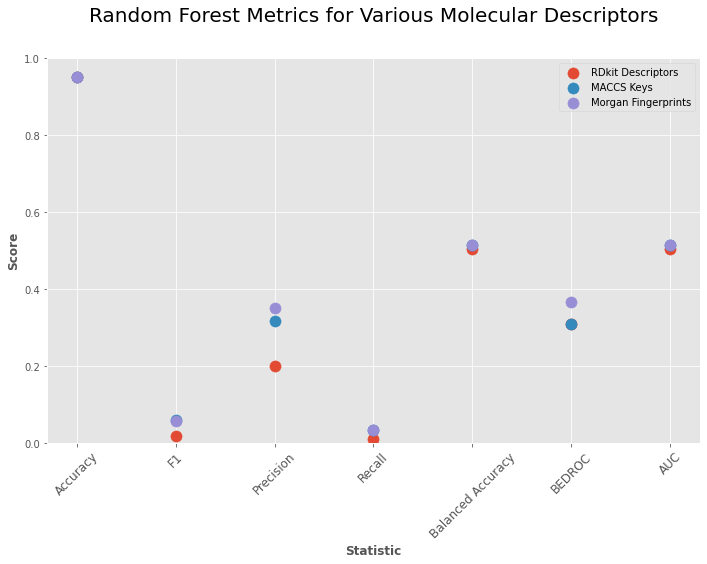

In [ ]:
df = pd.DataFrame({})

descriptors = ['Accuracy', 'F1', 'Precision', 'Recall', 'Balanced Accuracy', 'BEDROC', 'AUC']
rdkit = [0.9505529953917049,0.017786561264822136,0.2,0.009307359307359308,0.504532614278377,0.3089546912755955,0.504532614278377]
morgan = [0.9519220397890699,0.05769565217391306,0.35,0.031818181818181815,0.5153214079485828,0.36529299888980843,0.5153214079485828]
maccs = [0.9499101150527325,0.05800000000000001,0.31666666666666665,0.03203463203463204,0.5143724665282247,0.3075893977869473,0.5143724665282245]

plt.style.use('ggplot')
plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k')

# set width of bar
barWidth = 0.75
 
# set height of bar
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# Set position of bar on X axis
 
# Make the plot
bar1 = ax.scatter(descriptors, rdkit, s=125, label='RDkit Descriptors')
bar2 = ax.scatter(descriptors, maccs, s=125, label='MACCS Keys')
bar3 = ax.scatter(descriptors, morgan, s=125, label='Morgan Fingerprints')
# Add xticks on the middle of the group bars
plt.xlabel('Statistic', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks([r for r in range(len(rdkit))], descriptors, fontsize=12, rotation=45)

bottom, top = plt.ylim(0, 1)


# Create legend & Show graphic
plt.title("Random Forest Metrics for Various Molecular Descriptors", fontsize=20, y=1.08)
plt.legend()
plt.tight_layout()
plt.show()

> Based on the results above, we decided to use Morgan Fingerprints as our molecular descriptors, but also performed grid searching using the MACCS Keys descriptors at times since MACCS keys were not significantly worse than Morgan Fingerprints.

### Model training
* NOTE: For all grid searches, the code is redisplayed below but the code cells are not actually run in this notebook. The grid searches were performed in a different notebook and available upon request. The results of the grid search are displayed in a plot below

#### RF
* Grid search using 10× stratified kfold cross-validation

In [ ]:
from sklearn.metrics import make_scorer, matthews_corrcoef


scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

rf_clf=RandomForestClassifier(class_weight='balanced', 
                              random_state=0)

rf_param_grid={'n_estimators':list(range(1,1100,200)),
               'criterion': ['gini', 'entropy'], 
               'max_depth': [3, 10, 20, None]
               } 
               #'max_features':list(range(15,51,5)),

rf_clf_grid_search=GridSearchCV(rf_clf, rf_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC',
                                verbose=10
                                ) 

X = X_train_mm_i
y = y_train_mm_i.ravel()
rf_clf_grid_search.fit(X,y)

In [ ]:
covid_rf_output_df=pd.DataFrame(rf_clf_grid_search.cv_results_)
covid_rf_output_df.drop(list(covid_rf_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_rf_output_df.sort_values(by='rank_test_F1').head(2)) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.metrics import make_scorer, matthews_corrcoef


scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

rf_clf=RandomForestClassifier(class_weight='balanced', 
                              random_state=0)

rf_param_grid={'n_estimators':list(range(1,1100,200)),
               'criterion': ['gini', 'entropy'], 
               'max_depth': [3, 10, 20, None]
               } 
               #'max_features':list(range(15,51,5)),

rf_clf_grid_search=GridSearchCV(rf_clf, rf_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC',
                                verbose=10
                                ) 

X = X_train_mo_i
y = y_train_mo_i.ravel()
rf_clf_grid_search.fit(X,y)

In [ ]:
covid_rf_output_df=pd.DataFrame(rf_clf_grid_search.cv_results_)
covid_rf_output_df.drop(list(covid_rf_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_rf_output_df.sort_values(by='rank_test_F1').head(2)) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.metrics import make_scorer, matthews_corrcoef


scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

rf_clf=RandomForestClassifier(class_weight='balanced', 
                              random_state=0)

rf_param_grid={'n_estimators':list(range(1,1100,200)),
               'criterion': ['gini', 'entropy'], 
               'max_depth': [3, 10, 20, None]
               } 

rf_clf_grid_search=GridSearchCV(rf_clf, rf_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC',
                                verbose=10
                                ) 

X = X_train_ma_i
y = y_train_ma_i.ravel()
rf_clf_grid_search.fit(X,y)

In [ ]:
covid_rf_output_df=pd.DataFrame(rf_clf_grid_search.cv_results_)
covid_rf_output_df.drop(list(covid_rf_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_rf_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

#### SVMs (Support Vector Classifiers)
* Grid search using 10× stratified kfold cross-validation

In [ ]:
from sklearn.svm import SVC

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

svm_clf=SVC(kernel='rbf',
                class_weight='balanced',
                random_state=0)

svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}


svm_clf_grid_search=GridSearchCV(svm_clf,
                                 svm_param_grid,
                                 cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                 n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 scoring=scoring,
                                 refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

X = X_train_rd_i
y = y_train_rd_i.ravel()
svm_clf_grid_search.fit(X,y)

In [ ]:
covid_svm_output_df=pd.DataFrame(svm_clf_grid_search.cv_results_)
covid_svm_output_df.drop(list(covid_svm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_svm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.svm import SVC

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

svm_clf=SVC(kernel='rbf',
                class_weight='balanced',
                random_state=0)

svm_param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 0.01, 0.001]}


svm_clf_grid_search=GridSearchCV(svm_clf,
                                 svm_param_grid,
                                 cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                 n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 scoring=scoring,
                                 refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

X = X_train_mm_i
y = y_train_mm_i.ravel()
svm_clf_grid_search.fit(X,y)

In [ ]:
covid_svm_output_df=pd.DataFrame(svm_clf_grid_search.cv_results_)
covid_svm_output_df.drop(list(covid_svm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_svm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.svm import SVC

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

svm_clf=SVC(kernel='rbf',
                class_weight='balanced',
                random_state=0)

svm_param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 0.01, 0.001]}


svm_clf_grid_search=GridSearchCV(svm_clf,
                                 svm_param_grid,
                                 cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                 n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 scoring=scoring,
                                 refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

X = X_train_mo_i
y = y_train_mo_i.ravel()
svm_clf_grid_search.fit(X,y)

In [ ]:
covid_svm_output_df=pd.DataFrame(svm_clf_grid_search.cv_results_)
covid_svm_output_df.drop(list(covid_svm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_svm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.svm import SVC

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

svm_clf=SVC(kernel='rbf',
                class_weight='balanced',
                random_state=0)

svm_param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 0.01, 0.001]}


svm_clf_grid_search=GridSearchCV(svm_clf,
                                 svm_param_grid,
                                 cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                 n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 scoring=scoring,
                                 refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

X = X_train_ma_i
y = y_train_ma_i.ravel()
svm_clf_grid_search.fit(X,y)

In [ ]:
covid_svm_output_df=pd.DataFrame(svm_clf_grid_search.cv_results_)
covid_svm_output_df.drop(list(covid_svm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_svm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

#### Gradient Boosting Classifiers
* Grid search using 10× stratified kfold cross-validation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier #For GBM 

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

gbm_clf=GradientBoostingClassifier(random_state=0) 

gbm_param_grid={'learning_rate':[0.001,0.01], 
                'max_depth':list(range(5,20,10)), 
                'n_estimators':[50,100] 
                } 

gbm_clf_grid_search=GridSearchCV(gbm_clf, gbm_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


X = X_train_rd_i
y = y_train_rd_i.ravel()
gbm_clf_grid_search.fit(X,y)

In [ ]:
covid_gbm_output_df=pd.DataFrame(gbm_clf_grid_search.cv_results_)
covid_gbm_output_df.drop(list(covid_gbm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_gbm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier #For GBM 

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

gbm_clf=GradientBoostingClassifier(random_state=0) 

gbm_param_grid={'learning_rate':[0.001,0.01], 
                'max_depth':list(range(5,20,10)), 
                'n_estimators':[50,100] 
                } 

gbm_clf_grid_search=GridSearchCV(gbm_clf, gbm_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


X = X_train_mm_i
y = y_train_mm_i.ravel()
gbm_clf_grid_search.fit(X,y)

In [ ]:
covid_gbm_output_df=pd.DataFrame(gbm_clf_grid_search.cv_results_)
covid_gbm_output_df.drop(list(covid_gbm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_gbm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier #For GBM 

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

gbm_clf=GradientBoostingClassifier(random_state=0) 

gbm_param_grid={'learning_rate':[0.001,0.01], 
                'max_depth':list(range(5,20,10)), 
                'n_estimators':[50,100] 
                } 

gbm_clf_grid_search=GridSearchCV(gbm_clf, gbm_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


X = X_train_ma_i
y = y_train_ma_i.ravel()
gbm_clf_grid_search.fit(X,y)

In [ ]:
covid_gbm_output_df=pd.DataFrame(gbm_clf_grid_search.cv_results_)
covid_gbm_output_df.drop(list(covid_gbm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_gbm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier #For GBM 

scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

gbm_clf=GradientBoostingClassifier(random_state=0) 

gbm_param_grid={'learning_rate':[0.001,0.01], 
                'max_depth':list(range(5,20,10)), 
                'n_estimators':[50,100] 
                } 

gbm_clf_grid_search=GridSearchCV(gbm_clf, gbm_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


X = X_train_mo_i
y = y_train_mo_i.ravel()
gbm_clf_grid_search.fit(X,y)

In [ ]:
covid_gbm_output_df=pd.DataFrame(gbm_clf_grid_search.cv_results_)
covid_gbm_output_df.drop(list(covid_gbm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(covid_gbm_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

#### MLPs
* Grid search using 10× stratified kfold cross-validation

In [ ]:
from sklearn.neural_network import MLPClassifier
X = X_train_mo_i
y = y_train_mo_i.ravel()
kf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

accuracies = []
f1 = []
precisions = []
recalls = []
balanced_accuracy_scores = []
bedrocs = []
aucs = []
for train_index, test_index in kf.split(X, y):
  print('i')
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(10,10), random_state=1)
  clf.fit(X_train,y_train)

  y_pred = clf.predict(X_test)
  accuracies.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred))
  recalls.append(recall_score(y_test, y_pred))
  balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
  
  metric = dc.metrics.roc_auc_score
  aucs.append(metric(y_test, y_pred))

  y_pred_i = clf.predict_proba(X_test)
  metric = dc.metrics.bedroc_score
  bedrocs.append(metric(y_test, y_pred_i))
  
print("Avg Accuracy:",np.mean(accuracies))
print("Avg F1:",np.mean(f1))
print("Avg Precision:",np.mean(precisions))
print("Avg Recall:",np.mean(recalls))
print("Avg Balanced Accuracy:",np.mean(balanced_accuracy_scores))
print("Avg Bedroc:",np.mean(bedrocs))
print("Avg AUC:",np.mean(aucs))

Various ML Models with F1 score and 95% confidence interval


<Figure size 640x400 with 0 Axes>

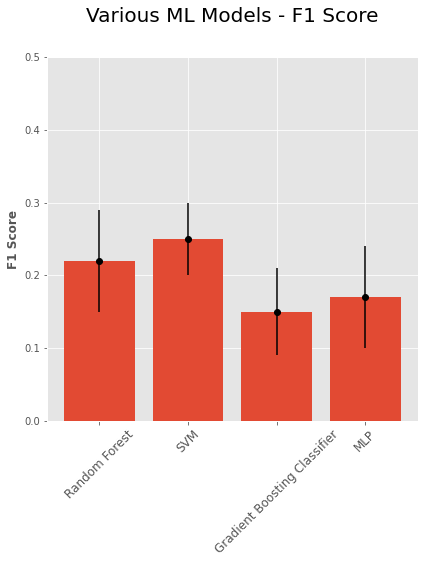

In [ ]:
model = ['Random Forest', 'SVM', 'Gradient Boosting Classifier', 'MLP']

f1 = [0.22, 0.25, 0.15, 0.17]
f1_error = [0.07, 0.05, 0.06, 0.07]


plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

# set width of bar
barWidth = 0.75
 
# set height of bar
fig, ax = plt.subplots()
fig.set_size_inches(6, 8)

# Set position of bar on X axis
 
# Make the plot
bar1 = ax.bar(model, f1)
ax.errorbar(model, f1,
                yerr=f1_error,fmt="o", color='black')
#bar2 = ax.scatter(model, test_values, s=125, label='Hold-Out Set')
# Add xticks on the middle of the group bars
#plt.xlabel('Statistic', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.xticks([r for r in range(len(f1))], model, fontsize=12, rotation=45)

bottom, top = plt.ylim(0, 0.5)

print("Various ML Models with F1 score and 95% confidence interval")
# Create legend & Show graphic
plt.title("Various ML Models - F1 Score", fontsize=20, y=1.08)
#plt.legend()
plt.tight_layout()
plt.show()


Various ML Models with Precision score and 95% confidence interval


<Figure size 640x400 with 0 Axes>

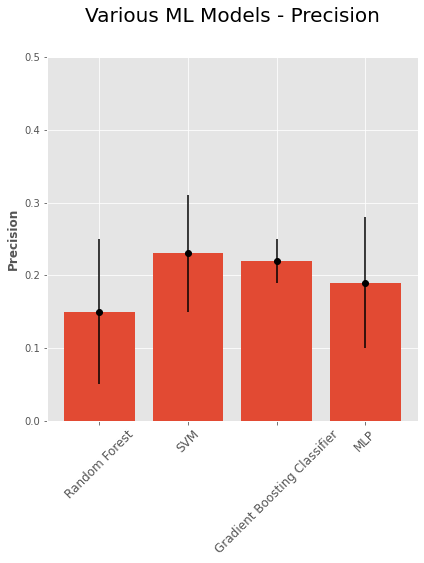

In [ ]:
model = ['Random Forest', 'SVM', 'Gradient Boosting Classifier', 'MLP']

precision = [0.15, 0.23, 0.22,0.19]
p_error = [0.1, 0.08, 0.03,0.09]


plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')

# set width of bar
barWidth = 0.75
 
# set height of bar
fig, ax = plt.subplots()
fig.set_size_inches(6, 8)

# Set position of bar on X axis
 
# Make the plot
bar1 = ax.bar(model, precision)
ax.errorbar(model, precision,
                yerr=p_error,fmt="o", color='black')
#bar2 = ax.scatter(model, test_values, s=125, label='Hold-Out Set')
# Add xticks on the middle of the group bars
#plt.xlabel('Statistic', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.xticks([r for r in range(len(precision))], model, fontsize=12, rotation=45)

bottom, top = plt.ylim(0, 0.5)

print("Various ML Models with Precision score and 95% confidence interval")

# Create legend & Show graphic
plt.title("Various ML Models - Precision", fontsize=20, y=1.08)
#plt.legend()
plt.tight_layout()
plt.show()

### Discussion of model performances
> Overall, it seems that Support Vector Machines/Classifiers are performing the best on this dataset. We are primarily looking at precision and F1 score when optimizing the models since we not only want to produce a set with an enriched probability of finding an inhibitor, but we also want the set to consist of multiple compounds. Overall, it appears that the  dataset is very imbalanced, which led us to create a new dataset that is curated in that it contains 50% inhibitors.

> With this new balanced dataset, we hope that our model would more easily be able to distinguish positive from negative compounds without predicting every compound as negative. 

## Balanced k-medoid-undersampled dataset 

### K-medoids undersampling
* The result is saved as a .csv file and uploaded into the GitHub page
* Basically, since the original dataset has lots of negatives, a k-medoid clustering will be performed on all the negatives with a k equal to the number of positives in the original dataset. By oding this, we undersampled the negatives in the original dataset in the most representative way.

In [ ]:
df_kmed=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/AntiVirusPrediction/RawData/cleaned_JL.csv?raw=true')
df_kmed

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Value,Positive
0,CHEMBL2169919,NaN,0,539.68,1,2.85,EPZ004777,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,8.88,0
1,CHEMBL1489,AZACITIDINE,4,244.21,0,-3.17,AZACITIDINE,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,-5.86,0
2,CHEMBL2179387,NaN,0,347.40,0,2.47,PFI-1(PF-6405761),COc1ccccc1S(=O)(=O)Nc1ccc2c(c1)CN(C)C(=O)N2,40.07,0
3,CHEMBL4303358,NaN,0,1007.21,None,None,OXYTOCIN (ACETATE),CC[C@H](C)C1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@...,5.61,0
4,CHEMBL2181226,NaN,0,399.49,1,5.12,TC-G-1005,Cc1ccc(C)c(Oc2ccncc2C(=O)N2CCN(C3CC3)c3ccccc32)c1,97.03,1
...,...,...,...,...,...,...,...,...,...,...
5586,CHEMBL1436121,NaN,0,286.72,0,1.87,OLPRINONE (HYDROCHLORIDE),Cc1[nH]c(=O)c(C#N)cc1-c1ccc2nccn2c1.Cl,16.73,0
5587,CHEMBL1487804,BENZOYLPAS,0,257.25,0,2.34,BENZOYLPAS,O=C(Nc1ccc(C(=O)O)c(O)c1)c1ccccc1,5.36,0
5588,CHEMBL1516068,NaN,0,329.87,0,4.93,CLOPERASTINE HYDROCHLORIDE,Clc1ccc([C@@H](OCCN2CCCCC2)c2ccccc2)cc1,2.27,0
5589,CHEMBL1525826,SULFALENE,4,280.31,0,0.87,SULFAMETOPYRAZINE,COc1nccnc1NS(=O)(=O)c1ccc(N)cc1,-11.78,0


In [ ]:
PandasTools.AddMoleculeColumnToFrame(df_kmed,'Smiles','Molecule')

Deal with imbalance issue by undersampling through K medoid clustering
1. Find out the number of positive cases as X
2. Use KMedoids methods to cluster into X groups basde on Tanimoto similarity
3. Take the centroids together as all the negative cases

In [ ]:
df_kmed['MorganFP']=[AllChem.GetMorganFingerprintAsBitVect(m,radius=2,nBits=1024) for m in df_kmed['Molecule']]

df_kmed['Positive'].value_counts()
#The classes are extremely imbalanced

0    5320
1     271
Name: Positive, dtype: int64

In [ ]:
positive_count=df_kmed['Positive'].value_counts().values[1]
positive_count

271

In [ ]:
negative_df=df_kmed[df_kmed['Positive']==0]
negative_df.shape

(5320, 12)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Value,Positive,Molecule,MorganFP
0,CHEMBL2169919,NaN,0,539.68,1,2.85,EPZ004777,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,8.88,0,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL1489,AZACITIDINE,4,244.21,0,-3.17,AZACITIDINE,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,-5.86,0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL2179387,NaN,0,347.40,0,2.47,PFI-1(PF-6405761),COc1ccccc1S(=O)(=O)Nc1ccc2c(c1)CN(C)C(=O)N2,40.07,0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL4303358,NaN,0,1007.21,None,None,OXYTOCIN (ACETATE),CC[C@H](C)C1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@...,5.61,0,,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
5,CHEMBL399910,PINOCEMBRIN,2,256.26,0,2.8,PINOCEMBRIN,O=C1C[C@@H](c2ccccc2)Oc2cc(O)cc(O)c21,-6.85,0,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5586,CHEMBL1436121,NaN,0,286.72,0,1.87,OLPRINONE (HYDROCHLORIDE),Cc1[nH]c(=O)c(C#N)cc1-c1ccc2nccn2c1.Cl,16.73,0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5587,CHEMBL1487804,BENZOYLPAS,0,257.25,0,2.34,BENZOYLPAS,O=C(Nc1ccc(C(=O)O)c(O)c1)c1ccccc1,5.36,0,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5588,CHEMBL1516068,NaN,0,329.87,0,4.93,CLOPERASTINE HYDROCHLORIDE,Clc1ccc([C@@H](OCCN2CCCCC2)c2ccccc2)cc1,2.27,0,,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
5589,CHEMBL1525826,SULFALENE,4,280.31,0,0.87,SULFAMETOPYRAZINE,COc1nccnc1NS(=O)(=O)c1ccc(N)cc1,-11.78,0,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

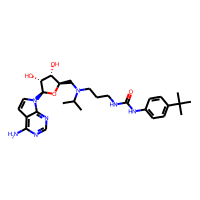
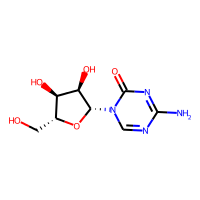
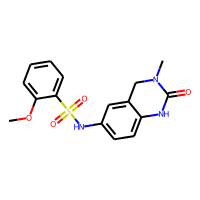
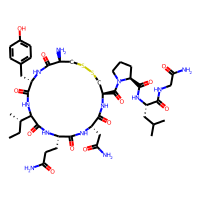
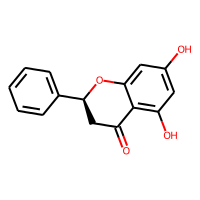
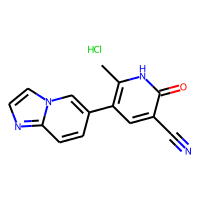
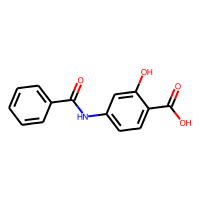
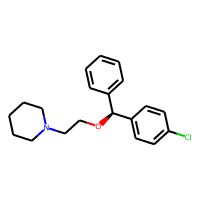
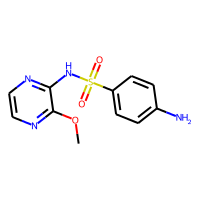
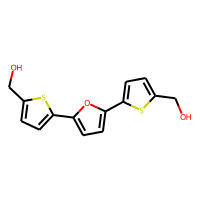

In [ ]:
negative_df

In [ ]:
morgan_array=np.array(list(negative_df['MorganFP']))
fp_df=pd.DataFrame(morgan_array,columns=['FP'+str(idx) for idx in list(range(1024))])
kmedoids = KMedoids(n_clusters=positive_count,random_state=0).fit(morgan_array)

/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 56 is empty! self.labels_[self.medoid_indices_[56]] may not be labeled with its corresponding cluster (56).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 67 is empty! self.labels_[self.medoid_indices_[67]] may not be labeled with its corresponding cluster (67).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 85 is empty! self.labels_[self.medoid_indices_[85]] may not be labeled with its corresponding cluster (85).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.7/dist-packages/sklearn_extra/cluster/_k_medoids.py:279: UserWarning: Cluster 113 is empty! self.labels_[self.medoid_indices_[113]] may not be labeled with its corresponding cluster (113).
  "its corresp

In [ ]:
pciked_negatives_idxes=kmedoids.medoid_indices_

In [ ]:
clustering_df=negative_df['Smiles'].rename_axis('Original index').reset_index()
clustering_df

,Original index,Smiles
0,0,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...
1,1,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1
2,2,COc1ccccc1S(=O)(=O)Nc1ccc2c(c1)CN(C)C(=O)N2
3,3,CC[C@H](C)C1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@...
4,5,O=C1C[C@@H](c2ccccc2)Oc2cc(O)cc(O)c21
...,...,...
5315,5586,Cc1[nH]c(=O)c(C#N)cc1-c1ccc2nccn2c1.Cl
5316,5587,O=C(Nc1ccc(C(=O)O)c(O)c1)c1ccccc1
5317,5588,Clc1ccc([C@@H](OCCN2CCCCC2)c2ccccc2)cc1
5318,5589,COc1nccnc1NS(=O)(=O)c1ccc(N)cc1


In [ ]:
pciked_negatives=clustering_df.iloc[pciked_negatives_idxes,:]
pciked_negatives.sort_index()

,Original index,Smiles
29,31,CCCCCCCCCCCCCCCCCCCCCCO
45,47,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1
70,72,N[C@@H](CC(=O)O)C(=O)O
72,74,CC(=O)Nc1ccccc1
82,84,O=C(CCCCCCC(=O)NO)NO
...,...,...
5185,5452,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...
5208,5475,COC(=O)c1ccccc1O
5227,5494,O=c1cc[nH]c(=O)[nH]1
5244,5511,Nc1ccncc1


In [ ]:
pciked_negatives_original_indexes=list(pciked_negatives['Original index'])
pciked_negatives_original_indexes.sort()
pciked_negatives_original_indexes

[31,
 47,
 72,
 74,
 84,
 86,
 95,
 115,
 122,
 159,
 161,
 170,
 173,
 195,
 254,
 260,
 265,
 273,
 277,
 320,
 334,
 356,
 386,
 411,
 415,
 433,
 435,
 517,
 520,
 524,
 527,
 530,
 534,
 537,
 555,
 567,
 580,
 614,
 624,
 632,
 634,
 658,
 726,
 775,
 783,
 799,
 807,
 829,
 898,
 911,
 937,
 942,
 954,
 956,
 980,
 985,
 1001,
 1016,
 1022,
 1039,
 1042,
 1103,
 1104,
 1118,
 1181,
 1186,
 1190,
 1196,
 1206,
 1218,
 1247,
 1254,
 1268,
 1270,
 1272,
 1303,
 1330,
 1418,
 1424,
 1426,
 1442,
 1466,
 1479,
 1492,
 1499,
 1506,
 1558,
 1571,
 1594,
 1615,
 1619,
 1635,
 1649,
 1661,
 1681,
 1682,
 1688,
 1691,
 1703,
 1710,
 1727,
 1759,
 1773,
 1774,
 1795,
 1861,
 1939,
 1973,
 2095,
 2122,
 2126,
 2131,
 2150,
 2188,
 2192,
 2218,
 2244,
 2262,
 2264,
 2291,
 2306,
 2312,
 2348,
 2381,
 2540,
 2554,
 2556,
 2584,
 2596,
 2669,
 2670,
 2683,
 2689,
 2723,
 2774,
 2783,
 2786,
 2821,
 2843,
 2869,
 2880,
 2882,
 2909,
 2941,
 2981,
 2994,
 3008,
 3064,
 3115,
 3130,
 3134,
 3179,

In [ ]:
all_positives=df_kmed[df_kmed['Positive']==1]
all_picked_negatives=df_kmed.iloc[pciked_negatives_original_indexes,:]
undersampled_df=pd.concat([all_positives,all_picked_negatives])
undersampled_df.rename_axis('Original index').reset_index().to_csv('undersampled_JL.csv',index=False) #undersampled_JL.csv is uploaded to the GitHub 

### Load/Preprocess Data

In [ ]:
subsamp_df = pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/AntiVirusPrediction/RawData/undersampled_JL.csv?raw=true') 

subsamp_df = subsamp_df[['Molecule ChEMBL ID', 'Smiles', 'Standard Value']]
subsamp_df.dropna(inplace=True)
PandasTools.AddMoleculeColumnToFrame(subsamp_df,'Smiles','molecule')
subsamp_df.reset_index(inplace=True)
subsamp_df['test'] = np.where(subsamp_df['Standard Value']> 75, 1, 0)

#RDKIT DESCRIPTORS
simpleList = [x[0] for x in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(simpleList)
descriptors_list = [calculator.CalcDescriptors(smile) for smile in subsamp_df['molecule']]
df_descriptor = pd.DataFrame(descriptors_list, columns=range(0,len(descriptors_list[0])))
df_rdkit_samp_i = pd.merge(subsamp_df, df_descriptor, left_index=True, right_index=True)
df_rdkit_samp_i.dropna(inplace=True)
df_rdkit_samp_i.reset_index(inplace=True)

#MORGAN FINGERPRINT DESCRIPTORS
morgan_list = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024).ToBitString() for m in subsamp_df['molecule']]
morgan_np = np.array([list(x) for x in morgan_list], dtype='int')
df_morgan = pd.DataFrame(morgan_np)
df_morgan_samp_i = pd.merge(subsamp_df, df_morgan, left_index=True, right_index=True)
df_morgan_samp_i.dropna(inplace=True)
df_morgan_samp_i.reset_index(inplace=True)

#MACCS KEYS DESCRIPTORS
maccs_list = [MACCSkeys.GenMACCSKeys(m) for m in subsamp_df['molecule']]
maccs_np = np.array([list(x) for x in maccs_list], dtype='int')
df_maccs = pd.DataFrame(maccs_np)
df_maccs_samp_i = pd.merge(subsamp_df, df_maccs, left_index=True, right_index=True)
df_maccs_samp_i.dropna(inplace=True)
df_maccs_samp_i.reset_index(inplace=True)

#RDKIT
X_rd_samp_i = df_rdkit_samp_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_rd_samp_i = df_rdkit_samp_i['test']
X_train_rd_samp_i, X_test_rd_samp_i, y_train_rd_samp_i, y_test_rd_samp_i = train_test_split(X_rd_samp_i,y_rd_samp_i,test_size=0.2, random_state=0, stratify=y_rd_samp_i)

rd_scaler= MinMaxScaler()
X_train_rd_samp_i = rd_scaler.fit_transform(X_train_rd_samp_i)
X_test_rd_samp_i = rd_scaler.transform(X_test_rd_samp_i)

#MORGAN
X_mo_samp_i = df_morgan_samp_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_mo_samp_i = df_morgan_samp_i['test']
X_train_mo_samp_i, X_test_mo_samp_i, y_train_mo_samp_i, y_test_mo_samp_i = train_test_split(X_mo_samp_i,y_mo_samp_i,test_size=0.2, random_state=0, stratify=y_mo_samp_i)

scaler= MinMaxScaler()
X_train_mo_samp_i = scaler.fit_transform(X_train_mo_samp_i)
X_test_mo_samp_i = scaler.transform(X_test_mo_samp_i)

#MACCS
X_ma_samp_i = df_maccs_samp_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_ma_samp_i = df_maccs_samp_i['test']
X_train_ma_samp_i, X_test_ma_samp_i, y_train_ma_samp_i, y_test_ma_samp_i = train_test_split(X_ma_samp_i,y_ma_samp_i,test_size=0.2, random_state=0, stratify=y_ma_samp_i)

scaler= MinMaxScaler()
X_train_ma_samp_i = scaler.fit_transform(X_train_ma_samp_i)
X_test_ma_samp_i = scaler.transform(X_test_ma_samp_i)

### Grid Search Random Forest

In [ ]:
from sklearn.metrics import make_scorer, matthews_corrcoef


scoring={'Recall':'recall',
             'Precision':'precision',
             'Accuracy':'accuracy',
              'F1':'f1',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

rf_clf=RandomForestClassifier(class_weight='balanced', 
                              random_state=0)

rf_param_grid={'n_estimators':list(range(1,1100,200)),
               'criterion': ['gini', 'entropy'], 
               'max_depth': [3, 10, 20, None]
               } 
               #'max_features':list(range(15,51,5)),

rf_clf_grid_search=GridSearchCV(rf_clf, rf_param_grid,
                                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=scoring,
                                refit='AUC',
                                verbose=10
                                ) 

X = X_train_rd_samp_i
y = y_train_rd_samp_i.ravel()
rf_clf_grid_search.fit(X,y)

In [ ]:
ppl_rf_output_df=pd.DataFrame(rf_clf_grid_search.cv_results_)
ppl_rf_output_df.drop(list(ppl_rf_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(ppl_rf_output_df.sort_values(by='rank_test_F1').head()) #Shows the top 5 best hyperparameter sets

In [ ]:
stat = ['Recall', 'Precision', 'Accuracy', 'F1', 'Balanced Accuracy', 'AUC', 'MCC']
val_values = [0.94,0.95,0.94,0.94,0.94,0.98,0.89]
val_errors = [0.03, 0.04, 0.03, 0.04, 0.05, 0.05, 0.07]
test_values = [0.9259259259259259, 0.9615384615384616, 0.9433962264150944, 0.9433962264150944, 0.9437321937321937, 0.9437321937321939, 0.8874643874643875]

<Figure size 640x1200 with 0 Axes>

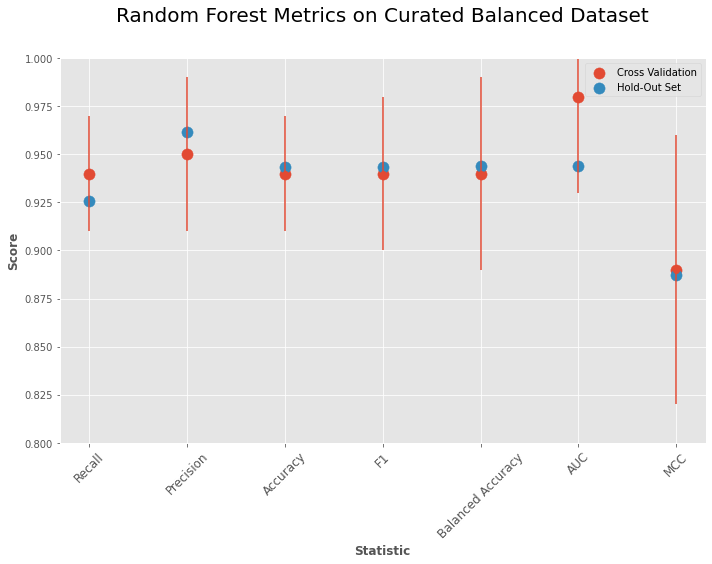

In [ ]:
plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k')

# set width of bar
barWidth = 0.75
 
# set height of bar
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# Set position of bar on X axis
 
# Make the plot
bar1 = ax.scatter(stat, val_values, s=125, label='Cross Validation')
bar2 = ax.scatter(stat, test_values, s=125, label='Hold-Out Set')
ax.errorbar(stat, val_values,
                yerr=val_errors,fmt="o")
# Add xticks on the middle of the group bars
plt.xlabel('Statistic', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks([r for r in range(len(rdkit))], stat, fontsize=12, rotation=45)
bottom, top = plt.ylim(0.8, 1)


# Create legend & Show graphic
plt.title("Random Forest Metrics on Curated Balanced Dataset", fontsize=20, y=1.08)
plt.legend()
plt.tight_layout()
plt.show()

### Final Model Performance on Balanced Dataset
* The below statistics are run on the hold out testing set that was not touched to see how well our model generalizes to new data. Keep in mind that this is only on our imbalanced data subset.

In [ ]:
X = X_train_rd_samp_i
y = y_train_rd_samp_i.ravel()

rf_final = RandomForestClassifier(n_estimators=201, random_state=0, max_depth=20, criterion='entropy', class_weight="balanced")
rf_final.fit(X,y)

y_pred = rf_final.predict(X_test_rd_samp_i)
y_test = y_test_rd_samp_i
print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1Score:",f1_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Balanced Accuracy Score:",balanced_accuracy_score(y_test, y_pred))

metric = dc.metrics.roc_auc_score
print("AUC:",metric(y_test, y_pred))

y_pred_i = rf_final.predict_proba(X_test_rd_samp_i)
metric = dc.metrics.bedroc_score
print("BEDROC:",metric(y_test, y_pred_i))

Accuracy: 0.9433962264150944
F1Score: 0.9433962264150944
Precision: 0.9615384615384616
Recall: 0.9259259259259259
Balanced Accuracy Score: 0.9437321937321937
AUC: 0.9437321937321939
BEDROC: 0.999903717534156


In [ ]:
y_test.index

Int64Index([252, 221, 254, 146,   2, 513, 133, 268,  17,  44,
            ...
            232, 358, 203,  66, 255, 340, 302, 299, 483, 455],
           dtype='int64', length=106)

In [ ]:
#predicting inhibitors on test set
a, b, c, d = train_test_split(df_rdkit_samp_i,y_rd_samp_i,test_size=0.2, random_state=0, stratify=y_rd_samp_i)
inhibitors = b[y_test.ravel().astype(bool)]
inhibitors.to_csv("inhibitors.csv")

### Try the above with a scrambled y_test

In [ ]:
import random
y_test = y_test_rd_samp_i.ravel().copy()
random.shuffle(y_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1Score:",f1_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Balanced Accuracy Score:",balanced_accuracy_score(y_test, y_pred))
metric = dc.metrics.roc_auc_score
print("AUC:",metric(y_test, y_pred))

Accuracy: 0.5094339622641509
F1Score: 0.509433962264151
Precision: 0.5192307692307693
Recall: 0.5
Balanced Accuracy Score: 0.5096153846153846
AUC: 0.5096153846153846


In [ ]:
X = X_train_rd_samp_i
y = y_train_rd_samp_i.ravel()
random.shuffle(y)

rf_final = RandomForestClassifier(n_estimators=201, random_state=0, max_depth=20, criterion='entropy', class_weight="balanced")
rf_final.fit(X,y)

y_pred = rf_final.predict(X_test_rd_samp_i)
y_test = y_test_rd_samp_i
print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1Score:",f1_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Balanced Accuracy Score:",balanced_accuracy_score(y_test, y_pred))

metric = dc.metrics.roc_auc_score
print("AUC:",metric(y_test, y_pred))

y_pred_i = rf_final.predict_proba(X_test_rd_samp_i)
metric = dc.metrics.bedroc_score
print("BEDROC:",metric(y_test, y_pred_i))

Accuracy: 0.46226415094339623
F1Score: 0.49557522123893805
Precision: 0.4745762711864407
Recall: 0.5185185185185185
Balanced Accuracy Score: 0.46118233618233617
AUC: 0.46118233618233617
BEDROC: 0.31614234052651585


> The above two codeblocks where I shuffled the y_test independently and also shuffled the entire dataset show very poor results on the final test set. This implies that the data is not being overfit.

### Feature Importance for Final Random Forest Model

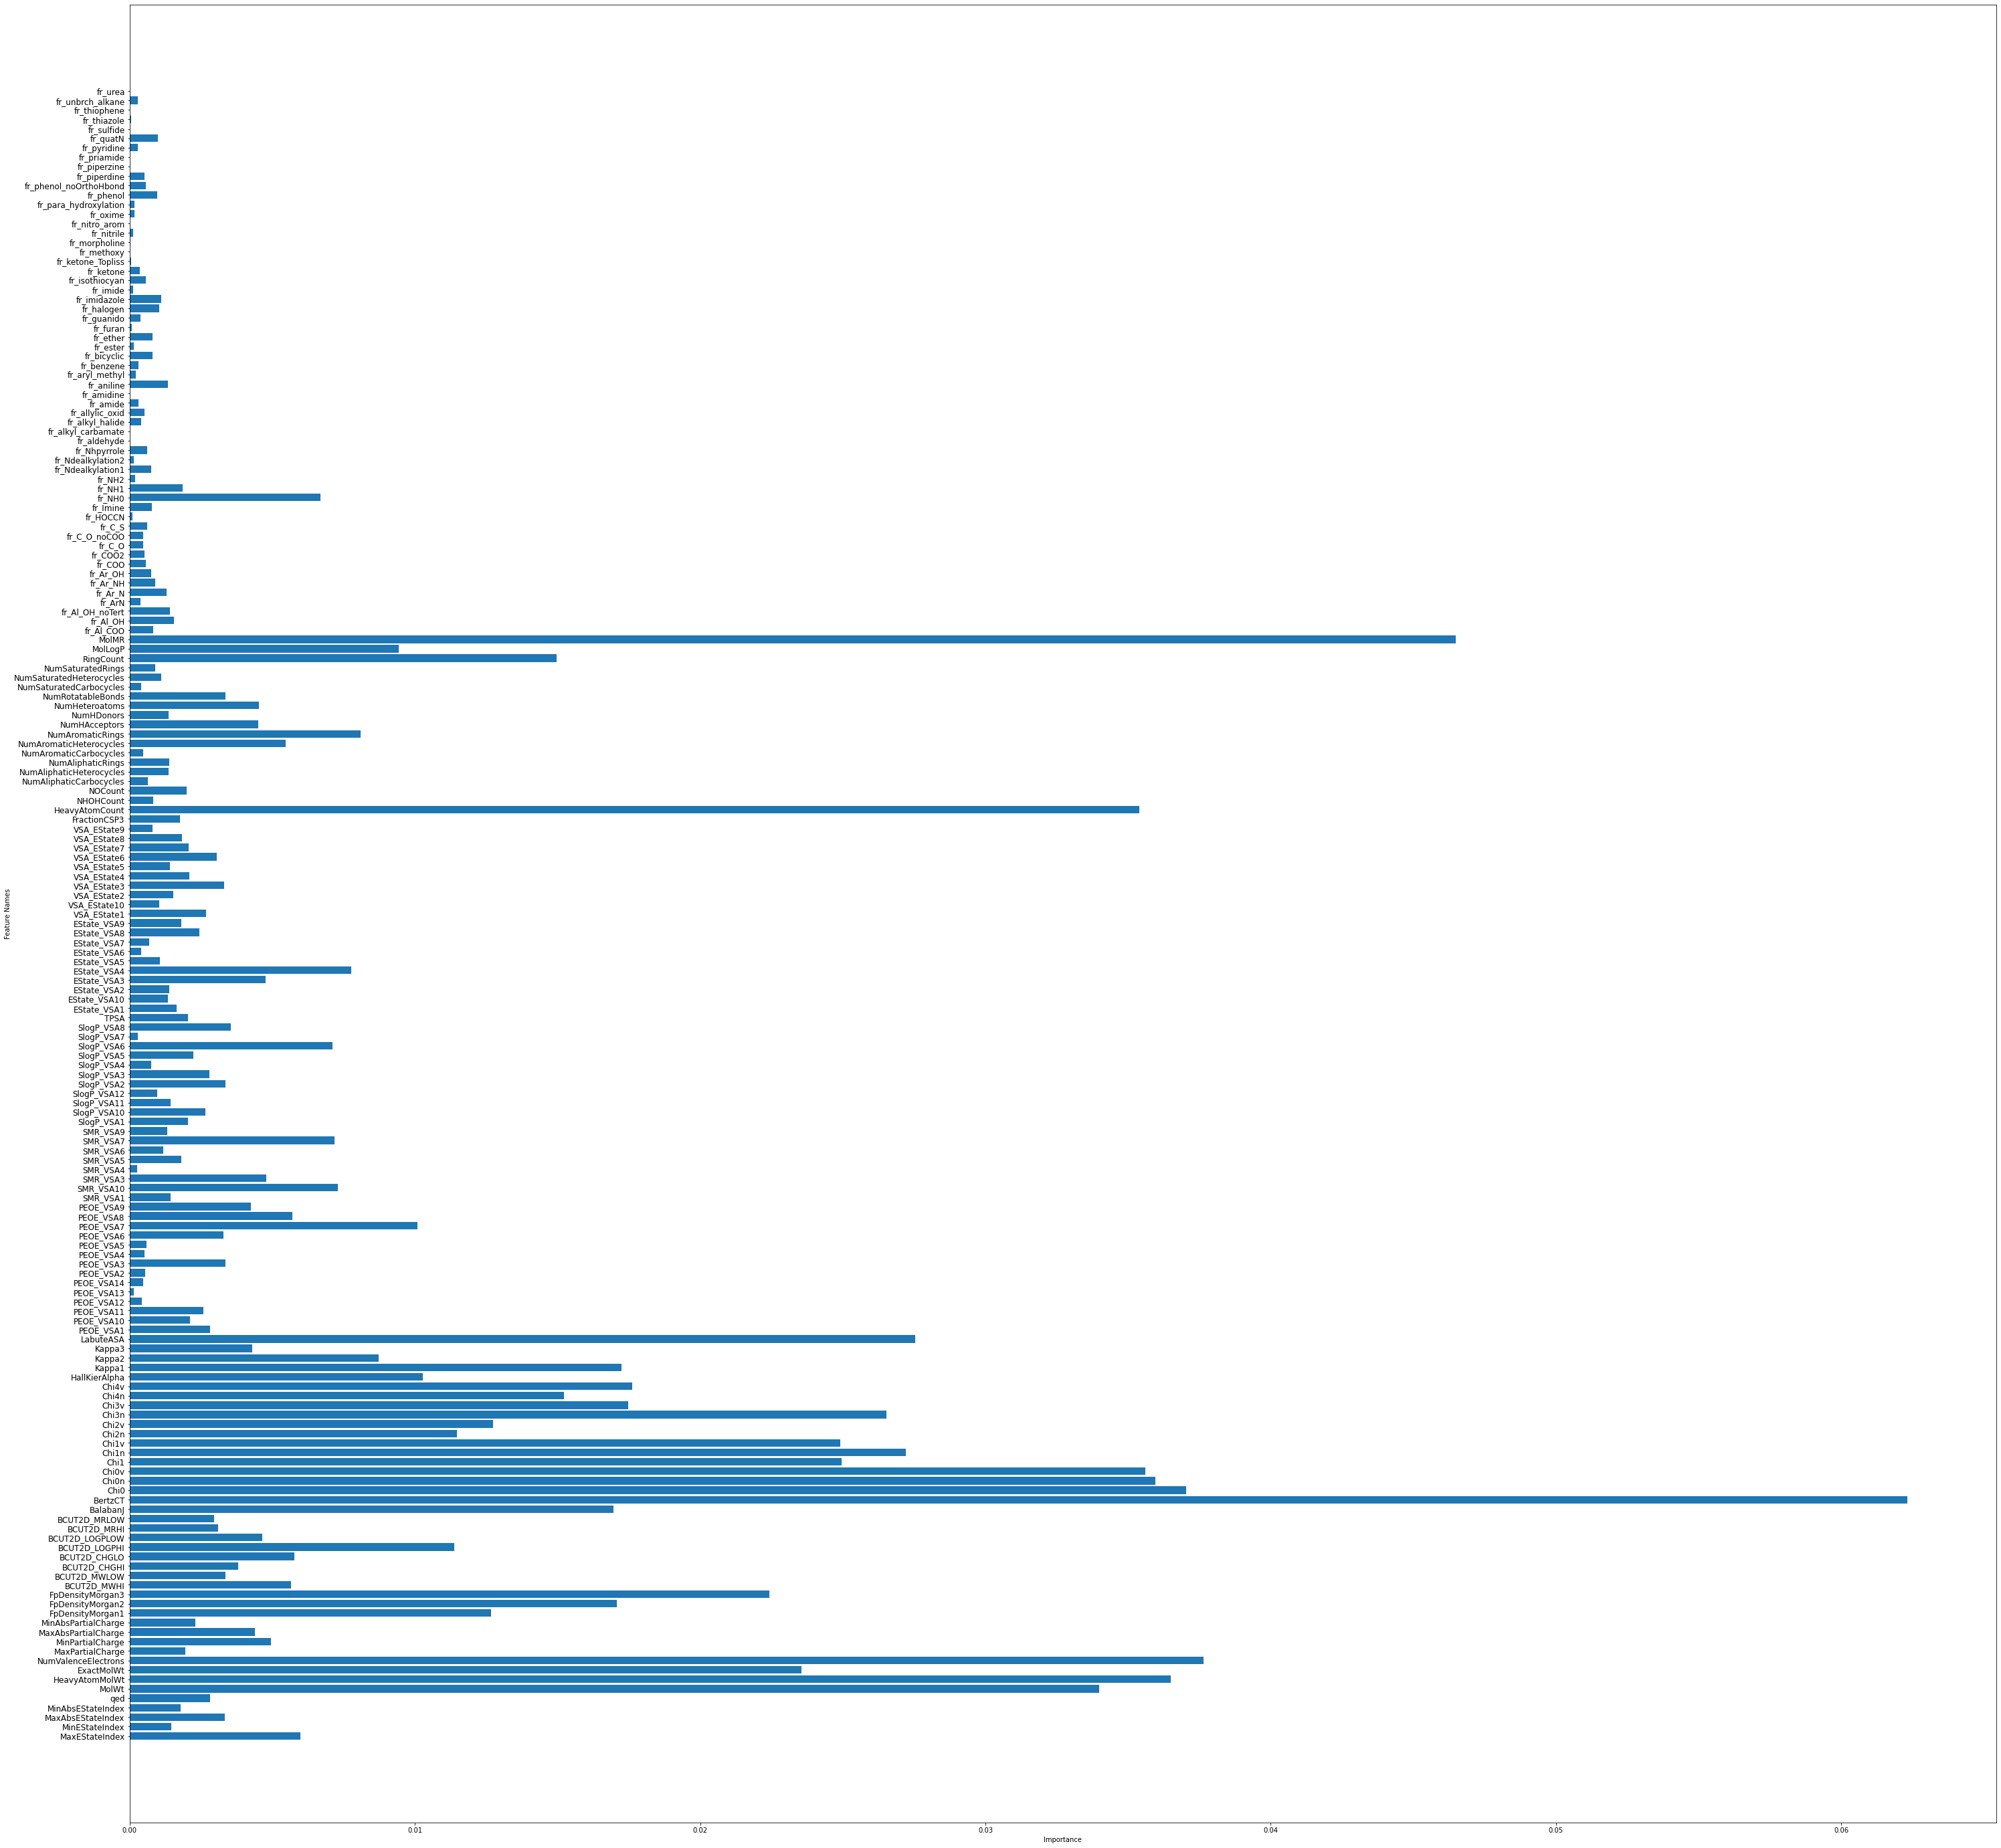

In [ ]:
importance = rf_final.feature_importances_.copy()
non_zero_index_list = [i for i, v in enumerate(importance) if v != 0]
non_zero_feature_names = [simpleList[i] for i in non_zero_index_list]
non_zero_importance = [importance[i] for i in non_zero_index_list]
fig,ax = plt.subplots(figsize=(50,50))
plt.barh(non_zero_feature_names, non_zero_importance)
ax.set_yticklabels(non_zero_feature_names, fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.show()

> The most important features for the random forest appear to be BertzCT ("a topological index meant to quantify complexity of molecules") and MolMR, which is the relative formula mass of a substance as defined by Wildman-Crippen.

### Testing Our Own Compounds
* We decided to use this finalized model to test out a few of our own compounds

In [ ]:
subsamp_df = pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/AntiVirusPrediction/RawData/undersampled_JL.csv?raw=true') 

subsamp_df = subsamp_df[['Molecule ChEMBL ID', 'Smiles', 'Standard Value']]
subsamp_df.dropna(inplace=True)
PandasTools.AddMoleculeColumnToFrame(subsamp_df,'Smiles','molecule')
subsamp_df.reset_index(inplace=True)
subsamp_df['test'] = np.where(subsamp_df['Standard Value']> 75, 1, 0)

#RDKIT DESCRIPTORS
simpleList = [x[0] for x in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(simpleList)
descriptors_list = [calculator.CalcDescriptors(smile) for smile in subsamp_df['molecule']]
df_descriptor = pd.DataFrame(descriptors_list, columns=range(0,len(descriptors_list[0])))
df_rdkit_samp_i = pd.merge(subsamp_df, df_descriptor, left_index=True, right_index=True)
df_rdkit_samp_i.dropna(inplace=True)
df_rdkit_samp_i.reset_index(inplace=True)

#RDKIT
X_rd_samp_i = df_rdkit_samp_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_rd_samp_i = df_rdkit_samp_i['test']
X_train_rd_samp_i, X_test_rd_samp_i, y_train_rd_samp_i, y_test_rd_samp_i = train_test_split(X_rd_samp_i,y_rd_samp_i,test_size=0.2, random_state=0, stratify=y_rd_samp_i)

scaler= MinMaxScaler()
X_train_rd_samp_i = scaler.fit_transform(X_train_rd_samp_i)
X_test_rd_samp_i = scaler.transform(X_test_rd_samp_i)


In [ ]:
new_descriptors_df = pd.DataFrame({'Smiles':['CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@@H]1[C@H]([C@H]([C@](O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4', 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O', 'CC(C(=O)OC(C)C(=O)O)O']})
PandasTools.AddMoleculeColumnToFrame(new_descriptors_df,'Smiles','molecule')

new_descriptors_list = [calculator.CalcDescriptors(smile) for smile in new_descriptors_df['molecule']]
new_descriptors_list = scaler.transform(new_descriptors_list)
y_pred = rf_final.predict(new_descriptors_list)


In [ ]:
y_pred

array([1, 0, 0])

> Remdesivir (the first compound) is predicted as an inhibitor as expected. Additionally, ibuprofen (the second compound) is predicted to not be an inhibitor of COVID-19 as expected. 

### How does the model trained on the balanced dataset perform on our overall imbalanced dataset?

In [ ]:
X = X_train_rd_samp_i
y = y_train_rd_samp_i.ravel()

rf_final = RandomForestClassifier(n_estimators=201, random_state=0, max_depth=20, criterion='entropy', class_weight="balanced")
rf_final.fit(X,y)

X_rd_i = df_rdkit_i.drop(['level_0', 'index','Molecule ChEMBL ID', 'Smiles', 'test', 'Standard Value', 'molecule'], axis=1)
y_rd_i = df_rdkit_i['test']

bad_indices = X_rd_i.loc[(X_rd_i[X_rd_i.columns] > 10e30).any(axis=1)].index
X_rd_i.drop(bad_indices, inplace=True)
y_rd_i.drop(bad_indices, inplace=True)

transform_X_rd_i = rd_scaler.transform(X_rd_i)

X = X_train_rd_samp_i
y = y_train_rd_samp_i.ravel()
y_pred = rf_final.predict(transform_X_rd_i)
y_test = y_rd_i

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1Score:",f1_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Balanced Accuracy Score:",balanced_accuracy_score(y_test, y_pred))

metric = dc.metrics.roc_auc_score
print("AUC:",metric(y_test, y_pred))

Accuracy: 0.27438687073575513
F1Score: 0.1187010078387458
Precision: 0.06315538608198284
Recall: 0.9851301115241635
Balanced Accuracy Score: 0.6112107678303782
AUC: 0.6112107678303783


> The AntiCovid model performed much better on the subsampled dataset compared to the overall dataset. This makes sense because there was a very large imbalance problem that we were facing when training models. Even when reweighting the loss between the classes to tell the model to focus more on predicting the positive classes, the recall was much lower than we were hoping for. Upon creating a balanced dataset using a k-medioids strategy that allowed us to obtain much better overall results. The model did not generalize as well to the overall dataset as it predicted a large proportion of the negatives to be COVID-19 inhibitors. However, this can be explained since the subsampled dataset is very small compared to the overall dataset and has the inhibitors in a higher proportion than the overall dataset. This could cause the models to generalize poorly. 

# AntiPhospho
* Since the phospholipidosis dataset is very small, I only picked models that are relatively simple--RF, GBM, and SVM. Deep learning models are excluded since they tend to get crazy on small datatsets. Extremely simple models like linear regression are also excluded for better performance. 
* Although both RF and GBM can output feature importances, SVM's input features are selected in a different manner. This is because these 3 models will be rather parallel base-level models for the meta learner. If the SVM is trained by the features that RF and/or GBM think are important, then probably SVM will perform very similarly to the RF and GBM, which will lost the purpose of the ensemble learning scheme. 
* All the options for hyperparameter tunning are either exactly the same or the used ones in the original literature or a subset of those due to the limitation of calculational power available to me. 
* All the GridSearchCV results will be stored in GitHub and further analysis will go from there. 

## Read the original data 

In [ ]:
ppl_df=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/RawData/ppl.csv?raw=true') #This is the .csv file for phospholipidosis
ppl_df

,Name,Smiles,PPL
0,AC-3579,O=N2=C4C3=C(N=C2CN1CCN(C)CC1)C=CC=C3C5=C4C=CC=C5,Pos
1,Acetaminophen,O=C(C)NC1=CC=C(O)C=C1,Neg
2,Amikacin,O(C2C(N)CC(NC(=O)C(O)CCN)C(OC1OC(CO)C(O)C(N)C1...,Pos
3,Amiodarone,IC3=C(OCCN(CC)CC)C(I)=CC(C(=O)C1C2=C(OC=1CCCC)...,Pos
4,Amitriptyline,N(C)(C)CCC=C2C1=C(C=CC=C1)CCC3=C2C=CC=C3,Pos
...,...,...,...
180,Thioridazine,S(C)C3=CC=C2SC4=C(N(CCC1N(C)CCCC1)C2=C3)C=CC=C4,Pos
181,Trimipramine,N(C)(C)CC(C)CN2C1=C(C=CC=C1)CCC3=C2C=CC=C3,Pos
182,Tripelennamine,N(C)(C)CCN(C1=NC=CC=C1)CC2=CC=CC=C2,Pos
183,Trospectomycin-sulfate,O2C(CCCC)CC(=O)C3(O)OC1C(NC)C(O)C(NC)C(O)C1OC23,Pos


In [ ]:
ppl_df.shape #You should have 185 molecules

(185, 3)

In [ ]:
ppl_df['PPL'].value_counts() #Slightly imbalanced

Pos    102
Neg     83
Name: PPL, dtype: int64

## Data preprocessing

### Numerize the label column 
* 0 (for Neg) and 1 (for Pos) 

In [ ]:
ppl_df['PPL']=np.where(ppl_df['PPL']=='Pos',1,0)
ppl_df

,Name,Smiles,PPL
0,AC-3579,O=N2=C4C3=C(N=C2CN1CCN(C)CC1)C=CC=C3C5=C4C=CC=C5,1
1,Acetaminophen,O=C(C)NC1=CC=C(O)C=C1,0
2,Amikacin,O(C2C(N)CC(NC(=O)C(O)CCN)C(OC1OC(CO)C(O)C(N)C1...,1
3,Amiodarone,IC3=C(OCCN(CC)CC)C(I)=CC(C(=O)C1C2=C(OC=1CCCC)...,1
4,Amitriptyline,N(C)(C)CCC=C2C1=C(C=CC=C1)CCC3=C2C=CC=C3,1
...,...,...,...
180,Thioridazine,S(C)C3=CC=C2SC4=C(N(CCC1N(C)CCCC1)C2=C3)C=CC=C4,1
181,Trimipramine,N(C)(C)CC(C)CN2C1=C(C=CC=C1)CCC3=C2C=CC=C3,1
182,Tripelennamine,N(C)(C)CCN(C1=NC=CC=C1)CC2=CC=CC=C2,1
183,Trospectomycin-sulfate,O2C(CCCC)CC(=O)C3(O)OC1C(NC)C(O)C(NC)C(O)C1OC23,1


### Molecular descriptors generation

In [ ]:
descriptors_list = [x[0] for x in Descriptors._descList] #This is a list of simple descriptors to be calculated

calc=MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

descriptor_list=[]
descriptor_list.append(descriptors_list)
for index, row in ppl_df.iterrows():
  smiles=row['Smiles']
  mol = Chem.MolFromSmiles(smiles)
  individual_list=list(calc.CalcDescriptors(mol))
  descriptor_list.append(individual_list)
  
descriptor_df=pd.DataFrame(descriptor_list)

new_header = descriptor_df.iloc[0] #grab the first row for the header
descriptor_df = descriptor_df[1:] #take the data less the header row
descriptor_df.columns = new_header #set the header row as the df header

descriptor_df=descriptor_df.reset_index(drop=True) #Reset the indexes for all the rows and drop the old index column 
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.1651,0.598061,13.1651,0.598061,0.417237,332.407,312.247,332.164,126,0,0.316207,-0.710243,0.710243,0.316207,0.96,1.68,2.48,16.47,10.0583,2.30113,-2.30998,2.44141,-2.4652,6.11157,-0.605504,1.64429,976.837,16.9659,14.2741,14.2741,12.2203,8.78027,8.78027,6.99572,6.99572,5.39958,5.39958,3.99578,3.99578,-2.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10.5245,-0.115102,10.5245,0.115102,0.595026,151.165,142.093,151.063,58,0,0.220747,-0.507964,0.507964,0.220747,1.36364,1.90909,2.36364,16.2547,10.2802,1.92804,-1.99455,2.12525,-2.04401,5.88095,-0.113736,2.7363,253.299,8.26758,6.16486,6.16486,5.18154,3.2491,3.2491,2.22806,2.22806,1.18767,1.18767,0.748027,0.748027,-1.51,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12.5784,-1.75583,12.5784,0.0100811,0.113064,585.608,542.264,585.286,234,0,0.2487,-0.393567,0.393567,0.2487,0.85,1.45,2.05,16.7242,9.83074,2.52209,-2.48515,2.31664,-2.69261,5.80396,-0.332238,1.8479,815.054,29.886,21.7015,21.7015,18.8519,13.0651,13.0651,10.3342,10.3342,7.50894,7.50894,5.06708,5.06708,-1.17,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.588,0.0153483,13.588,0.0153483,0.167647,645.319,616.087,645.024,166,0,0.19675,-0.490031,0.490031,0.19675,1.06452,1.74194,2.3871,126.914,9.98085,2.23002,-2.18779,2.33055,-2.2768,14.1137,0.10332,1.88886,1017.42,22.3801,18.3417,22.6567,14.9939,10.8887,13.0462,7.47344,9.79782,5.46166,7.06425,3.6483,5.72782,-1.13,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2.41963,1.0883,2.41963,1.0883,0.813678,277.411,254.227,277.183,108,0,0.00101376,-0.309092,0.309092,0.00101376,0.857143,1.38095,1.90476,15.0441,9.93062,2.16318,-2.12934,2.33058,-2.11662,5.83409,0.417087,2.06595,602.893,14.6565,12.9718,12.9718,10.254,7.76939,7.76939,6.02404,6.02404,4.20352,4.20352,3.10355,3.10355,-1.86,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.56283,0.724699,2.56283,0.724699,0.619208,370.587,344.379,370.154,132,0,0.0563597,-0.33955,0.33955,0.0563597,1.08,1.92,2.76,32.1677,9.99425,2.25442,-2.36903,2.48564,-2.38247,7.99528,0.178021,1.63034,746.426,17.2254,15.0724,16.7054,12.2584,9.18758,11.2288,6.97397,8.9374,5.44031,7.29592,3.96396,5.47368,-1.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
181,2.53356,0.619641,2.53356,0.619641,0.836647,294.442,268.234,294.21,116,0,0.0443057,-0.34072,0.34072,0.0443057,0.909091,1.40909,1.90909,15.1542,10.0495,2.21213,-2.30325,2.35821,-2.30335,5.70626,0.342829,1.98509,585.609,15.5267,13.919,13.919,10.6479,8.22975,8.22975,6.73545,6.73545,4.39

### Add in the Structural alerts (SA)

In [ ]:
sa_df=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/RawData/ppl_sa.csv?raw=true')
sa_df.drop(columns=['MOLECULEID','SMILES'],inplace=True)
sa_df

,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,TA1088,TA1099,TA1101,TA1152,TA1158,TA1162,TA1301,TA1302,TA1303,TA1304,TA1307,TA1319,TA1340,TA1343,TA1344,TA1345,TA2615,TA2620,TA2621,TA2623,TA2639,TA2652,TA2653,TA2654,TA3007,TA3035,TA3036,TA9488,TA9492,TA9493,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
descriptor_df=pd.concat([descriptor_df, sa_df], axis=1) #Exclude the 'SMILES' column from the sa_df since it cannot be part of the feature dataset
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,13.1651,0.598061,13.1651,0.598061,0.417237,332.407,312.247,332.164,126,0,0.316207,-0.710243,0.710243,0.316207,0.96,1.68,2.48,16.47,10.0583,2.30113,-2.30998,2.44141,-2.4652,6.11157,-0.605504,1.64429,976.837,16.9659,14.2741,14.2741,12.2203,8.78027,8.78027,6.99572,6.99572,5.39958,5.39958,3.99578,3.99578,-2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.5245,-0.115102,10.5245,0.115102,0.595026,151.165,142.093,151.063,58,0,0.220747,-0.507964,0.507964,0.220747,1.36364,1.90909,2.36364,16.2547,10.2802,1.92804,-1.99455,2.12525,-2.04401,5.88095,-0.113736,2.7363,253.299,8.26758,6.16486,6.16486,5.18154,3.2491,3.2491,2.22806,2.22806,1.18767,1.18767,0.748027,0.748027,-1.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.5784,-1.75583,12.5784,0.0100811,0.113064,585.608,542.264,585.286,234,0,0.2487,-0.393567,0.393567,0.2487,0.85,1.45,2.05,16.7242,9.83074,2.52209,-2.48515,2.31664,-2.69261,5.80396,-0.332238,1.8479,815.054,29.886,21.7015,21.7015,18.8519,13.0651,13.0651,10.3342,10.3342,7.50894,7.50894,5.06708,5.06708,-1.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.588,0.0153483,13.588,0.0153483,0.167647,645.319,616.087,645.024,166,0,0.19675,-0.490031,0.490031,0.19675,1.06452,1.74194,2.3871,126.914,9.98085,2.23002,-2.18779,2.33055,-2.2768,14.1137,0.10332,1.88886,1017.42,22.3801,18.3417,22.6567,14.9939,10.8887,13.0462,7.47344,9.79782,5.46166,7.06425,3.6483,5.72782,-1.13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.41963,1.0883,2.41963,1.0883,0.813678,277.411,254.227,277.183,108,0,0.00101376,-0.309092,0.309092,0.00101376,0.857143,1.38095,1.90476,15.0441,9.93062,2.16318,-2.12934,2.33058,-2.11662,5.83409,0.417087,2.06595,602.893,14.6565,12.9718,12.9718,10.254,7.76939,7.76939,6.02404,6.02404,4.20352,4.20352,3.10355,3.10355,-1.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.56283,0.724699,2.56283,0.724699,0.619208,370.587,344.379,370.154,132,0,0.0563597,-0.33955,0.33955,0.0563597,1.08,1.92,2.76,32.1677,9.99425,2.25442,-2.36903,2.48564,-2.38247,7.99528,0.178021,1.63034,746.426,17.2254,15.0724,16.7054,12.2584,9.18758,11.2288,6.97397,8.9374,5.44031,7.29592,3.96396,5.47368,-1.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,2.53356,0.619641,2.53356,0.619641,0.836647,

Add in the label column 

In [ ]:
descriptor_df['Y']=ppl_df['PPL'] #Concatenate the new descriptor dataframe with Y column of the original drug dataframe
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297,Y
0,13.1651,0.598061,13.1651,0.598061,0.417237,332.407,312.247,332.164,126,0,0.316207,-0.710243,0.710243,0.316207,0.96,1.68,2.48,16.47,10.0583,2.30113,-2.30998,2.44141,-2.4652,6.11157,-0.605504,1.64429,976.837,16.9659,14.2741,14.2741,12.2203,8.78027,8.78027,6.99572,6.99572,5.39958,5.39958,3.99578,3.99578,-2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.5245,-0.115102,10.5245,0.115102,0.595026,151.165,142.093,151.063,58,0,0.220747,-0.507964,0.507964,0.220747,1.36364,1.90909,2.36364,16.2547,10.2802,1.92804,-1.99455,2.12525,-2.04401,5.88095,-0.113736,2.7363,253.299,8.26758,6.16486,6.16486,5.18154,3.2491,3.2491,2.22806,2.22806,1.18767,1.18767,0.748027,0.748027,-1.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,12.5784,-1.75583,12.5784,0.0100811,0.113064,585.608,542.264,585.286,234,0,0.2487,-0.393567,0.393567,0.2487,0.85,1.45,2.05,16.7242,9.83074,2.52209,-2.48515,2.31664,-2.69261,5.80396,-0.332238,1.8479,815.054,29.886,21.7015,21.7015,18.8519,13.0651,13.0651,10.3342,10.3342,7.50894,7.50894,5.06708,5.06708,-1.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,13.588,0.0153483,13.588,0.0153483,0.167647,645.319,616.087,645.024,166,0,0.19675,-0.490031,0.490031,0.19675,1.06452,1.74194,2.3871,126.914,9.98085,2.23002,-2.18779,2.33055,-2.2768,14.1137,0.10332,1.88886,1017.42,22.3801,18.3417,22.6567,14.9939,10.8887,13.0462,7.47344,9.79782,5.46166,7.06425,3.6483,5.72782,-1.13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.41963,1.0883,2.41963,1.0883,0.813678,277.411,254.227,277.183,108,0,0.00101376,-0.309092,0.309092,0.00101376,0.857143,1.38095,1.90476,15.0441,9.93062,2.16318,-2.12934,2.33058,-2.11662,5.83409,0.417087,2.06595,602.893,14.6565,12.9718,12.9718,10.254,7.76939,7.76939,6.02404,6.02404,4.20352,4.20352,3.10355,3.10355,-1.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.56283,0.724699,2.56283,0.724699,0.619208,370.587,344.379,370.154,132,0,0.0563597,-0.33955,0.33955,0.0563597,1.08,1.92,2.76,32.1677,9.99425,2.25442,-2.36903,2.48564,-2.38247,7.99528,0.178021,1.63034,746.426,17.2254,15.0724,16.7054,12.2584,9.18758,11.2288,6.97397,8.9374,5.44031,7.29592,3.96396,5.47368,-1.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
181,2.53356,0.619641,2.53356,0.619641,0.836647,294.442,268.234,2

### Cleaning

In [ ]:
print('Before cleaning, you have', len(descriptor_df),'datapoints')
descriptor_df=descriptor_df.dropna() #By default, dropna(axis=0) which means drop rows which contain missing values
print('After cleaning, you have', len(descriptor_df),'datapoints')
descriptor_df

Before cleaning, you have 185 datapoints
After cleaning, you have 185 datapoints


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297,Y
0,13.1651,0.598061,13.1651,0.598061,0.417237,332.407,312.247,332.164,126,0,0.316207,-0.710243,0.710243,0.316207,0.96,1.68,2.48,16.47,10.0583,2.30113,-2.30998,2.44141,-2.4652,6.11157,-0.605504,1.64429,976.837,16.9659,14.2741,14.2741,12.2203,8.78027,8.78027,6.99572,6.99572,5.39958,5.39958,3.99578,3.99578,-2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.5245,-0.115102,10.5245,0.115102,0.595026,151.165,142.093,151.063,58,0,0.220747,-0.507964,0.507964,0.220747,1.36364,1.90909,2.36364,16.2547,10.2802,1.92804,-1.99455,2.12525,-2.04401,5.88095,-0.113736,2.7363,253.299,8.26758,6.16486,6.16486,5.18154,3.2491,3.2491,2.22806,2.22806,1.18767,1.18767,0.748027,0.748027,-1.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,12.5784,-1.75583,12.5784,0.0100811,0.113064,585.608,542.264,585.286,234,0,0.2487,-0.393567,0.393567,0.2487,0.85,1.45,2.05,16.7242,9.83074,2.52209,-2.48515,2.31664,-2.69261,5.80396,-0.332238,1.8479,815.054,29.886,21.7015,21.7015,18.8519,13.0651,13.0651,10.3342,10.3342,7.50894,7.50894,5.06708,5.06708,-1.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,13.588,0.0153483,13.588,0.0153483,0.167647,645.319,616.087,645.024,166,0,0.19675,-0.490031,0.490031,0.19675,1.06452,1.74194,2.3871,126.914,9.98085,2.23002,-2.18779,2.33055,-2.2768,14.1137,0.10332,1.88886,1017.42,22.3801,18.3417,22.6567,14.9939,10.8887,13.0462,7.47344,9.79782,5.46166,7.06425,3.6483,5.72782,-1.13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.41963,1.0883,2.41963,1.0883,0.813678,277.411,254.227,277.183,108,0,0.00101376,-0.309092,0.309092,0.00101376,0.857143,1.38095,1.90476,15.0441,9.93062,2.16318,-2.12934,2.33058,-2.11662,5.83409,0.417087,2.06595,602.893,14.6565,12.9718,12.9718,10.254,7.76939,7.76939,6.02404,6.02404,4.20352,4.20352,3.10355,3.10355,-1.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.56283,0.724699,2.56283,0.724699,0.619208,370.587,344.379,370.154,132,0,0.0563597,-0.33955,0.33955,0.0563597,1.08,1.92,2.76,32.1677,9.99425,2.25442,-2.36903,2.48564,-2.38247,7.99528,0.178021,1.63034,746.426,17.2254,15.0724,16.7054,12.2584,9.18758,11.2288,6.97397,8.9374,5.44031,7.29592,3.96396,5.47368,-1.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
181,2.53356,0.619641,2.53356,0.619641,0.836647,294.442,268.234,2

In [ ]:
#These are the full data 
whole_descriptor_df_X=descriptor_df.loc[:, descriptor_df.columns != 'Y']
whole_descriptor_df_y=descriptor_df['Y']

### Hold-out method to have the real test set 
* This will be used as completely unknown data to prevent overfitting

In [ ]:
ppl_X_train, ppl_X_test, ppl_y_train, ppl_y_test = train_test_split(whole_descriptor_df_X, whole_descriptor_df_y, 
                                                                    test_size=0.2, 
                                                                    stratify=whole_descriptor_df_y, #Stratified split
                                                                    random_state=0)

descriptor_df_X=ppl_X_train
descriptor_df_y=ppl_y_train

### Feature scaling
* Required by SVM

In [ ]:
svm_scaler=StandardScaler()
descriptor_df_X_scaled_array=svm_scaler.fit_transform(descriptor_df_X) #fit_transform outputs an array and it will lost the feature names (column headers)

descriptor_df_X_scaled=pd.DataFrame(descriptor_df_X_scaled_array,columns=descriptor_df_X.columns) #Remake the df for the transformed data from the array and add back the columns

descriptor_df_X_scaled
#Each feature's Gaussian distribution is now centered around 0 and it's standard deviation is 1

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,-1.083245,0.801723,-1.083245,0.353553,-1.379053,0.793896,0.675447,0.794872,1.015553,0.0,-0.712509,-0.971243,0.898331,-0.781934,-2.034749,-2.506578,-2.648850,-0.612570,-0.659787,-0.170363,-0.124296,0.355356,0.307193,-0.833676,0.300144,-0.119626,0.017762,0.934887,1.361213,1.254036,1.032795,1.449715,1.238921,0.811800,0.617886,1.009598,0.836535,0.757452,0.596543,-0.202281,...,-0.082479,-0.082479,0.0,0.0,0.0,0.0,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
1,-1.867874,1.142799,-1.867874,1.611672,1.190778,-0.477043,-0.501165,-0.476134,-0.410209,0.0,-1.246646,0.707895,-0.781649,-1.384790,-0.680713,-0.760553,-0.650821,-0.715572,0.046986,-0.305307,-0.123069,0.230428,0.542828,-0.515196,1.535968,-0.093944,-0.340427,-0.435636,-0.275802,-0.344350,-0.281195,-0.154404,-0.247684,-0.285519,-0.399570,-0.176320,-0.285729,-0.095987,-0.215112,0.008795,...,-0.082479,-0.082479,0.0,0.0,0.0,0.0,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
2,1.202414,-1.174772,1.202414,-0.382100,-1.880568,1.163536,1.169580,1.164841,1.247653,0.0,-0.050928,-1.136760,1.063931,-0.035238,0.069267,0.155238,0.243034,-0.624866,-1.320513,1.780431,-1.467613,1.018929,-1.718150,0.065385,-0.667180,-0.661040,1.265480,1.305829,1.205636,1.102130,1.275660,1.246637,1.050720,1.481240,1.238604,1.598230,1.393573,1.672311,1.466611,-1.266452,...,-0.082479,-0.082479,0.0,0.0,0.0,0.0,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
3,0.226996,-0.049411,0.226996,-0.495114,-0.336946,-0.116391,-0.063728,-0.118636,-0.310737,0.0,0.680857,-0.841906,0.768929,0.790693,1.076566,1.265621,1.290121,0.849252,0.154403,-0.760565,0.674547,-0.170312,1.527483,1.531017,-0.578942,0.290838,-0.025646,-0.233434,-0.361762,-0.187861,-0.270551,-0.500982,-0.231965,-0.579862,-0.291598,-0.626108,-0.338395,-0.747375,-0.461749,0.017590,...,-0.082479,-0.082479,0.0,0.0,0.0,0.0,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,0.0,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
4,0.252887,0.467190,0.252887,-0.589046,0.842434,-1.024575,-1.022881,-1.023550,-0.973882,0.0,0.017020,-0.989258,0.916355,0.041451,1.089950,0.847853,0.394301,-0.612891,0.643619,-1.313516,1.035984,-0.547866,1.386873,-0.357952,-0.530271,0.949587,-0.866693,-0.948200,-0.944227,-0.997002,-1.003403,-1.021796,-1.051532,-1.128137,-1.180862,-1.156697,-1.213485,-1.071

### Feature selection


In [ ]:
#Check for low variance
feature_selector=VarianceThreshold(threshold=0) #The default threshold for variance is 0--this removes the constant features that are the same for all the datapoints

print('Before removing the zero-variance descriptors, the dataset has',len(descriptor_df_X_scaled.columns),'descriptors')

feature_selector.fit_transform(descriptor_df_X_scaled)



descriptor_df_X_scaled_varianced=pd.DataFrame(feature_selector.fit_transform(descriptor_df_X_scaled),
                                              columns=descriptor_df_X_scaled.columns[feature_selector.get_support(indices=True)] #get_support(indices=True) returns the indices of the kept descriptors 
                                              )


print('After removing the zero-variance descriptors, the dataset has',len(descriptor_df_X_scaled_varianced.columns),'descriptors')

descriptor_df_X_scaled_varianced

Before removing the zero-variance descriptors, the dataset has 1038 descriptors
After removing the zero-variance descriptors, the dataset has 949 descriptors


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,...,TA1846,TA9813,TA10577,TA10615,TA2329,TA10324,TA11186,TA2624,TA2626,TA2666,TA2671,TA10264,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10813,TA686,TA858,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA10297
0,-1.083245,0.801723,-1.083245,0.353553,-1.379053,0.793896,0.675447,0.794872,1.015553,-0.712509,-0.971243,0.898331,-0.781934,-2.034749,-2.506578,-2.648850,-0.612570,-0.659787,-0.170363,-0.124296,0.355356,0.307193,-0.833676,0.300144,-0.119626,0.017762,0.934887,1.361213,1.254036,1.032795,1.449715,1.238921,0.811800,0.617886,1.009598,0.836535,0.757452,0.596543,-0.202281,-0.082479,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
1,-1.867874,1.142799,-1.867874,1.611672,1.190778,-0.477043,-0.501165,-0.476134,-0.410209,-1.246646,0.707895,-0.781649,-1.384790,-0.680713,-0.760553,-0.650821,-0.715572,0.046986,-0.305307,-0.123069,0.230428,0.542828,-0.515196,1.535968,-0.093944,-0.340427,-0.435636,-0.275802,-0.344350,-0.281195,-0.154404,-0.247684,-0.285519,-0.399570,-0.176320,-0.285729,-0.095987,-0.215112,0.008795,-0.082479,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
2,1.202414,-1.174772,1.202414,-0.382100,-1.880568,1.163536,1.169580,1.164841,1.247653,-0.050928,-1.136760,1.063931,-0.035238,0.069267,0.155238,0.243034,-0.624866,-1.320513,1.780431,-1.467613,1.018929,-1.718150,0.065385,-0.667180,-0.661040,1.265480,1.305829,1.205636,1.102130,1.275660,1.246637,1.050720,1.481240,1.238604,1.598230,1.393573,1.672311,1.466611,-1.266452,-0.082479,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
3,0.226996,-0.049411,0.226996,-0.495114,-0.336946,-0.116391,-0.063728,-0.118636,-0.310737,0.680857,-0.841906,0.768929,0.790693,1.076566,1.265621,1.290121,0.849252,0.154403,-0.760565,0.674547,-0.170312,1.527483,1.531017,-0.578942,0.290838,-0.025646,-0.233434,-0.361762,-0.187861,-0.270551,-0.500982,-0.231965,-0.579862,-0.291598,-0.626108,-0.338395,-0.747375,-0.461749,0.017590,-0.082479,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
4,0.252887,0.467190,0.252887,-0.589046,0.842434,-1.024575,-1.022881,-1.023550,-0.973882,0.017020,-0.98925

In [ ]:
#Check for highly-correlated (a correlation > 0.95) descriptors

#If you want to see correlation heatmap. This will take a while for a huge number of descriptors
# correlation_plot = corrplot.Corrplot(descriptor_df_X_scaled_varianced.corr())
# correlation_plot.plot(colorbar=True, method='square', lower='square',shrink=.9 ,rotation=45)

#Filter out descriptors with correlation over 0.95
corr_matrix = descriptor_df_X_scaled_varianced.corr().abs() #Create correlation matrix. The default method used here for correlation is Pearson
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #Select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)] #Find index of feature columns with correlation greater than 0.95

print('Before removing the highly-correlated descriptors, the dataset has',len(descriptor_df_X_scaled_varianced.columns),'descriptors')
descriptor_df_X_scaled_varianced_correlated=descriptor_df_X_scaled_varianced.drop(to_drop, axis=1) #Drop features 
print('After removing the highly-correlated descriptors, the dataset has',len(descriptor_df_X_scaled_varianced_correlated.columns),'descriptors')

descriptor_df_X_scaled_varianced_correlated

Before removing the highly-correlated descriptors, the dataset has 949 descriptors
After removing the highly-correlated descriptors, the dataset has 521 descriptors


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,HallKierAlpha,Ipc,Kappa2,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,...,TA10608,TA420,TA917,TA2726,TA1723,TA374,TA228,TA11264,TA646,TA584,TA992,TA2526,TA391,TA10281,TA10283,TA937,TA9913,TA2628,TA11498,TA10307,TA264,TA563,TA908,TA1164,TA833,TA665,TA927,TA1215,TA2525,TA621,TA2329,TA2624,TA10264,TA237,TA686,TA10208,TA2935,TA759,TA10257,TA2104
0,-1.083245,0.801723,0.353553,-1.379053,0.793896,-0.712509,-0.971243,-0.781934,-2.034749,-2.506578,-2.648850,-0.612570,-0.659787,-0.170363,-0.124296,0.355356,0.307193,-0.833676,0.300144,-0.119626,0.017762,-0.202281,-0.082479,2.201065,0.330722,0.186860,1.522789,-0.623952,-0.524943,-0.213398,-0.667206,-0.778338,-0.638162,-0.306938,-0.326785,1.976907,1.738498,-0.335027,-0.912298,-0.322391,...,-0.117041,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.166667,-0.143839,-0.143839,-0.082479,-0.143839,-0.082479,-0.082479,-0.143839,-0.082479,-0.082479,-0.117041,-0.143839,-0.186989,-0.117041,-0.205557,-0.082479,-0.143839,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
1,-1.867874,1.142799,1.611672,1.190778,-0.477043,-1.246646,0.707895,-1.384790,-0.680713,-0.760553,-0.650821,-0.715572,0.046986,-0.305307,-0.123069,0.230428,0.542828,-0.515196,1.535968,-0.093944,-0.340427,0.008795,-0.082479,-0.324229,-0.236923,-0.385417,-0.804609,-0.623952,-0.524943,-0.213398,-0.667206,-0.778338,-0.638162,-0.306938,-0.326785,0.537143,0.562965,-0.034912,-0.912298,-0.861819,...,-0.117041,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.166667,-0.143839,-0.143839,-0.082479,-0.143839,-0.082479,-0.082479,-0.143839,-0.082479,-0.082479,-0.117041,-0.143839,-0.186989,-0.117041,-0.205557,-0.082479,-0.143839,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
2,1.202414,-1.174772,-0.382100,-1.880568,1.163536,-0.050928,-1.136760,-0.035238,0.069267,0.155238,0.243034,-0.624866,-1.320513,1.780431,-1.467613,1.018929,-1.718150,0.065385,-0.667180,-0.661040,1.265480,-1.266452,-0.082479,0.407549,-0.146882,0.918308,0.804117,2.063031,2.096355,-0.213398,-0.667206,2.570315,-0.638162,-0.306938,-0.326785,-0.650784,0.909620,-0.066639,1.293680,1.410989,...,-0.117041,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.166667,-0.143839,-0.143839,-0.082479,-0.143839,-0.082479,-0.082479,-0.143839,-0.082479,-0.082479,-0.117041,-0.143839,-0.186989,-0.117041,-0.205557,-0.082479,-0.143839,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
3,0.226996,-0.049411,-0.495114,-0.336946,-0.116391,0.680857,-0.841906,0.790693,1.076566,1.265621,1.290121,0.849252,0.154403,-0.760565,0.674547,-0.170312,1.527483,1.531017,-0.578942,0.290838,-0.025646,0.017590,-0.082479,-0.147881,-0.070923,-0.372361,0.228614,0.178442,-0.524943,-0.213398,0.868270,-0.114443,1.651384,-0.306938,-0.326785,0.492954,-0.415157,-0.418025,-0.380752,-0.298058,...,-0.117041,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.166667,-0.143839,-0.143839,-0.082479,-0.143839,-0.082479,-0.082479,-0.143839,-0.082479,-0.082479,-0.117041,-0.143839,-0.186989,-0.117041,-0.205557,-0.082479,-0.143839,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
4,0.252887,0.467190,-0.589046,0.842434,-1.024575,0.017020,-0.989258,0.041451,1.089950,0.84

### Feature enginerring by PCA
* PCA is effected by scale so features in the dataset were scaled before applying PCA
* Number of PC will be used for the meta learner training
* We picked the number of PCs to have an overall variance of 0.95, which is the conventional threshold

Overall variance captured by the 1st 90 PCs is 0.9485177418746897


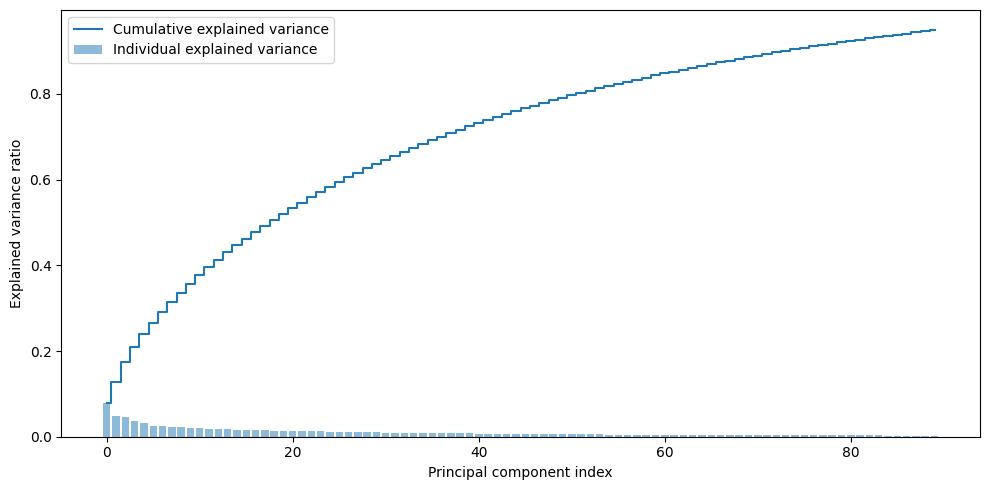

In [ ]:
pc_num=90 #This controls how many PC you want to keep

ppl_pca=PCA(n_components=pc_num).fit(descriptor_df_X_scaled_varianced_correlated)
descriptor_df_X_scaled_varianced_correlated_pca=PCA(n_components=pc_num).fit_transform(descriptor_df_X_scaled_varianced_correlated)


ppl_pca_explain_variance=ppl_pca.explained_variance_ratio_
cum_sum_eigenvalues = ppl_pca_explain_variance.cumsum()

print('Overall variance captured by the 1st',pc_num,'PCs is',cum_sum_eigenvalues[pc_num-1]) #pc_num-1 to ensure you don't go over the index of the list cum_sum_eigenvalues

plt.figure(figsize=(10, 5),dpi=100)
plt.bar(range(0,len(ppl_pca_explain_variance)), ppl_pca_explain_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3 base learners training

### Cross-validation and scoring strategy 

In [ ]:
ppl_cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                               n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                               random_state=0)

ppl_scoring={'Sensitivity':'recall',
             'Specificity':make_scorer(recall_score,pos_label=0), #Default for make_scorer(recall_score) is sensitivity with pos_label=1. pos_label=0 gives specificity
             'Precision':'precision',
            # 'Accuracy':'accuracy',
             'Balanced accuracy':'balanced_accuracy',
             'AUC':'roc_auc',
             'MCC':make_scorer(matthews_corrcoef)}

### SVM

In [ ]:
#GridSearchCV
svm_clf=svm.SVC(kernel='rbf',
                class_weight='balanced',
                random_state=0) #rbf kernel was used in the literature Radial Basis Function Kernel The Radial basis function kernel is a popular kernel function commonly used in support vector machine classification. RBF can map an input space in infinite dimensional space

svm_C_gamma_test_step=0.25 #Use 0.25 here if you want to have the same C and gamma lists as the literature
C_list=[] #Stores list of C. The range is determined by the literature
C_initial=-5
for idx in range(81): #Use range(81) here if you want to have the same C list as the literature
  C_list.append(2**C_initial)
  C_initial+=svm_C_gamma_test_step
  if C_initial>15: #This is the max for C in the original literature
    break

gamma_list=[] #Stores list of gamma. The range is determined by the literature
gamma_initial=-19
for idx in range(89): #Use range(89) here if you want to have the same gamma list as the literature 
  gamma_list.append(2**gamma_initial)
  gamma_initial+=svm_C_gamma_test_step
  if gamma_initial>3: #This is the max for gamma in the original literature
    break

svm_param_grid={'C':C_list, #Regularization parameter
                'gamma':gamma_list #Kernel coefficient
                }


svm_clf_grid_search=GridSearchCV(svm_clf,
                                 svm_param_grid,
                                 cv=ppl_cv,
                                 n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 scoring=ppl_scoring,
                                 refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

svm_clf_grid_search.fit(descriptor_df_X_scaled_varianced_correlated_pca,descriptor_df_y)


#Display the top several models 
ppl_svm_output_df=pd.DataFrame(svm_clf_grid_search.cv_results_)
ppl_svm_output_df.drop(list(ppl_svm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(ppl_svm_output_df.sort_values(by='rank_test_Sensitivity').head()) #Shows the top 5 best hyperparameter sets


#Save the best model
dump_pickle(svm_clf_grid_search,'svm GridSearchCV results.pkl')

svm_best_model=svm_clf_grid_search.best_estimator_
display(svm_best_model)

### RF

In [ ]:
#GridSearchCV
rf_clf=RandomForestClassifier(class_weight='balanced', #Because the dataset is slightly imbalanced
                              random_state=0) 
#The generalization error for forests converges as the number of trees in the forest become large. You can pick a large number of tress since our computation time is not limiting (because our data is very small)
#If you want to see how much time remains, add verbose=1 to the model line. I took it out since the output is too much

rf_param_grid={'n_estimators':list(range(1,1100,100)), #The later literature used 1000 trees
               'criterion': ['gini', 'entropy'], 
               'max_features':list(range(1,51,1)) #'max_features':list(range(1,51,1)) is from the literature
               } 

rf_clf_grid_search=GridSearchCV(rf_clf, rf_param_grid,
                                cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                                                           n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                                                           random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=ppl_scoring,
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

rf_clf_grid_search.fit(descriptor_df_X,descriptor_df_y)



#Display the top several models 
ppl_rf_output_df=pd.DataFrame(rf_clf_grid_search.cv_results_)
ppl_rf_output_df.drop(list(ppl_rf_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(ppl_rf_output_df.sort_values(by='rank_test_Sensitivity').head()) #Shows the top 5 best hyperparameter sets


#Save the best model
dump_pickle(rf_clf_grid_search,'rf GridSearchCV results.pkl')

rf_best_model=rf_clf_grid_search.best_estimator_
display(rf_best_model)

### GBM

In [ ]:
#GridSearchCV
gbm_clf=GradientBoostingClassifier(random_state=0) 

gbm_param_grid={'learning_rate':[0.001,0.01,0.1], #Literature used [0.001,0.01,0.1]. Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. Default is 0.1. Lowering will slow down the learning
                'max_depth':list(range(5,26,5)), #Literature used list(range(5,26,5). The maximum depth of the individual regression estimators or the tree complexity
                'n_estimators':[50,100,500] #Literature used [50,100,500]. The number of trees (default is 100). Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
               } # len(list(ParameterGrid(RF_param_grid)))

gbm_clf_grid_search=GridSearchCV(gbm_clf, gbm_param_grid,
                                cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                                                           n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                                                           random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring=ppl_scoring,
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

gbm_clf_grid_search.fit(descriptor_df_X,descriptor_df_y)



#Display the top several models 
ppl_gbm_output_df=pd.DataFrame(gbm_clf_grid_search.cv_results_)
ppl_gbm_output_df.drop(list(ppl_gbm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(ppl_gbm_output_df.sort_values(by='rank_test_Sensitivity').head()) #Shows the top 5 best hyperparameter sets


#Save the best model
dump_pickle(gbm_clf_grid_search,'gbm GridSearchCV results.pkl')

gbm_best_model=gbm_clf_grid_search.best_estimator_
display(gbm_best_model)

## Stacking RF classifier training

#### Train meta learner with already trained base learners 

In [ ]:
#GridSearchCV
estimators = [('svm', Pipeline(steps=[('scaling',StandardScaler()),
                                      ('variance',VarianceThreshold(threshold=0)),
                                      ('correlation',SelectNonCollinear(correlation_threshold=0.95)), #Method used here is Pearson's. Same as the one you used by the corr() method
                                      ('pca',PCA(n_components=90,
                                                 random_state=0)
                                      ), 
                                      ('clf',svm_best_model)
                                      ]
                               )
               ),
               ('rf', rf_best_model),
               ('gbm',gbm_best_model)
              ]

meta_clf = StackingClassifier(estimators=estimators, 
                              final_estimator=RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0),
                              )

params= {'final_estimator__n_estimators':list(range(1,1200,100)),
         'final_estimator__criterion':['gini','entropy']}

meta_clf_grid_search = GridSearchCV(estimator=meta_clf, 
                             param_grid=params,
                             cv=ppl_cv,
                             n_jobs=-1,
                             scoring=ppl_scoring,
                            refit='AUC' #Otherwise the grid search will refit the estimator on the whole dataset (ignoring cv) after the grid search completes
                            ) 

meta_clf_grid_search.fit(descriptor_df_X,descriptor_df_y)


#Display the top several models 
ppl_meta_output_df=pd.DataFrame(meta_clf_grid_search.cv_results_)
ppl_meta_output_df.drop(list(ppl_meta_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
display(ppl_meta_output_df.sort_values(by='rank_test_Sensitivity').head()) #Shows the top 5 best hyperparameter sets


#Save the best model
dump_pickle(meta_clf_grid_search,'meta GridSearchCV results.pkl')

meta_best_model=meta_clf_grid_search.best_estimator_
display(meta_best_model)

## Comparision of the 4 models' performances 
* Also include a shuffeling method as an adversarial control

In [ ]:
#Reload the GridSearch objects from GitHub
pickle_url_dict={'svm':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/svm%20GridSearchCV%20results.pkl',
                 'rf':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/rf%20GridSearchCV%20results.pkl',
                 'gbm':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/gbm%20GridSearchCV%20results.pkl',
                 'meta rf':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/meta%20GridSearchCV%20results.pkl'}

ppl_model_dict={}
for pickle_model_name, pickle_url in pickle_url_dict.items():
  temp_grid_search=load_cloud_pickle(pickle_url)
  temp_cv_results=pd.DataFrame(temp_grid_search.cv_results_)
  temp_cv_results.drop(list(temp_cv_results.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
  display(temp_cv_results.sort_values(by='rank_test_Sensitivity').head(1)) 
  ppl_model_dict[pickle_model_name]=temp_grid_search.best_estimator_

ppl_model_dict #This is a dict of usable models

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator SVC from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


,param_C,param_gamma,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
7208,32768,8,"{'C': 32768.0, 'gamma': 8.0}",1.0,1,0.020635,5685,0.559719,4049,0.510317,4093,0.574289,7114,0.040634,4087


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Us

,param_criterion,param_max_features,param_n_estimators,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
552,entropy,1,201,"{'criterion': 'entropy', 'max_features': 1, 'n...",0.853704,1,0.680159,990,0.772664,979,0.766931,326,0.868259,217,0.554729,172


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid resul

,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
0,0.001,5,50,"{'learning_rate': 0.001, 'max_depth': 5, 'n_es...",1.0,1,0.0,41,0.554286,41,0.5,41,0.706763,45,0.0,41


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator VarianceThreshold from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator PCA from version 0.22.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. Fo

,param_final_estimator__criterion,param_final_estimator__n_estimators,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
0,gini,1,"{'final_estimator__criterion': 'gini', 'final_...",0.772685,1,0.663492,24,0.752045,24,0.718089,23,0.718089,23,0.445537,23


{'gbm': GradientBoostingClassifier(max_depth=5, random_state=0),
 'meta rf': StackingClassifier(estimators=[('svm',
                                 Pipeline(steps=[('scaling', StandardScaler()),
                                                 ('variance',
                                                  VarianceThreshold(threshold=0)),
                                                 ('correlation',
                                                  <collinearity.SelectNonCollinear.SelectNonCollinear object at 0x7f7fa74031d0>),
                                                 ('pca',
                                                  PCA(n_components=90,
                                                      random_state=0)),
                                                 ('clf',
                                                  SVC(C=1.189207115002721,
                                                      class_weight='balanced',
                                                     

#### Performance on the hold-out test set 

In [ ]:
hold_out_performance_dict={}
for model_name, best_model in ppl_model_dict.items():

  if model_name == 'svm': #SVM need the pipeline
    best_svm_clf_pipeline=Pipeline(steps=[('scaling',StandardScaler()),
                                          ('variance',VarianceThreshold(threshold=0)),
                                          ('correlation',SelectNonCollinear(correlation_threshold=0.95)), #Method used here is Pearson's. Same as the one you used by the corr() method
                                          ('pca',PCA(n_components=90,
                                                      random_state=0)
                                          ), 
                                          ('clf',best_model)
                                          ]
                                  )

    best_model_pred=best_svm_clf_pipeline.fit(descriptor_df_X,descriptor_df_y).predict(ppl_X_test)
  elif model_name=='rf': #Somehow if I directly use the RF model here, I will get an error for RF. So I have to extract the parameters from the RF model and make a new one. Something got messed up about the min_impurity_split during the pickle and unpickle process
      best_params=best_model.get_params()
      temp_rf=RandomForestClassifier()
      temp_rf.set_params(**best_params)
      best_model_pred=temp_rf.fit(descriptor_df_X,descriptor_df_y).predict(ppl_X_test)
  else: #GBM is all cool
    best_model_pred=best_model.fit(descriptor_df_X,descriptor_df_y).predict(ppl_X_test)


  hold_out_performance_dict[model_name]=[recall_score(ppl_y_test,best_model_pred),
                                         roc_auc_score(ppl_y_test,best_model_pred),
                                         matthews_corrcoef(ppl_y_test,best_model_pred)
                                         ]
  

pd.DataFrame.from_dict(hold_out_performance_dict,
                       orient='index',
                       columns=['Recall','AUC','MCC']) 






,Recall,AUC,MCC
svm,0.90,0.832353,0.674702
rf,0.90,0.832353,0.674702
gbm,0.85,0.836765,0.673529
meta rf,0.85,0.866176,0.730208


#### Performance on a shuffled dataset 

In [ ]:
descriptor_df_X_shuffled=shuffle(descriptor_df_X,random_state=1972)

shuffle_performance_dict={}
for model_name, best_model in ppl_model_dict.items():

  if model_name == 'svm': #SVM need the pipeline
    best_svm_clf_pipeline=Pipeline(steps=[('scaling',StandardScaler()),
                                          ('variance',VarianceThreshold(threshold=0)),
                                          ('correlation',SelectNonCollinear(correlation_threshold=0.95)), #Method used here is Pearson's. Same as the one you used by the corr() method
                                          ('pca',PCA(n_components=90,
                                                      random_state=0)
                                          ), 
                                          ('clf',best_model)
                                          ]
                                  )

    best_model_pred=best_svm_clf_pipeline.fit(descriptor_df_X_shuffled,descriptor_df_y).predict(ppl_X_test)
  elif model_name=='rf': #Somehow if I directly use the RF model here, I will get an error for RF. So I have to extract the parameters from the RF model and make a new one. Something got messed up about the min_impurity_split during the pickle and unpickle process
      best_params=best_model.get_params()
      temp_rf=RandomForestClassifier()
      temp_rf.set_params(**best_params)
      best_model_pred=temp_rf.fit(descriptor_df_X_shuffled,descriptor_df_y).predict(ppl_X_test)
  else: #GBM and the meta is all cool
    best_model_pred=best_model.fit(descriptor_df_X_shuffled,descriptor_df_y).predict(ppl_X_test)


  shuffle_performance_dict[model_name]=[recall_score(ppl_y_test,best_model_pred),
                                         roc_auc_score(ppl_y_test,best_model_pred),
                                         matthews_corrcoef(ppl_y_test,best_model_pred)
                                         ]
  

pd.DataFrame.from_dict(shuffle_performance_dict,
                       orient='index',
                       columns=['Recall','AUC','MCC']) 

,Recall,AUC,MCC
svm,0.25,0.360294,-0.287115
rf,0.60,0.447059,-0.110531
gbm,0.80,0.547059,0.109323
meta rf,0.45,0.430882,-0.137831


### Performance plot

In [ ]:
performance_df=pd.read_csv('https://raw.githubusercontent.com/junqilu/AntiSARSCoV2Prediction/main/PhospholipidosisPrediction/ModelPerformance/models%20performances.csv')
performance_df

,Models,Datasets,Metrics,Values,CI
0,svm,hold-out,recall,0.900000,0.040000
1,svm,hold-out,AUC,0.832353,0.056324
2,svm,hold-out,MCC,0.674702,0.021747
3,svm,shuffled,recall,0.250000,0.041500
4,svm,shuffled,AUC,0.360294,0.043603
5,svm,shuffled,MCC,-0.287115,0.017129
6,rf,hold-out,recall,0.900000,0.051000
7,rf,hold-out,AUC,0.832353,0.047324
8,rf,hold-out,MCC,0.674702,0.023000
9,rf,shuffled,recall,0.600000,0.040000


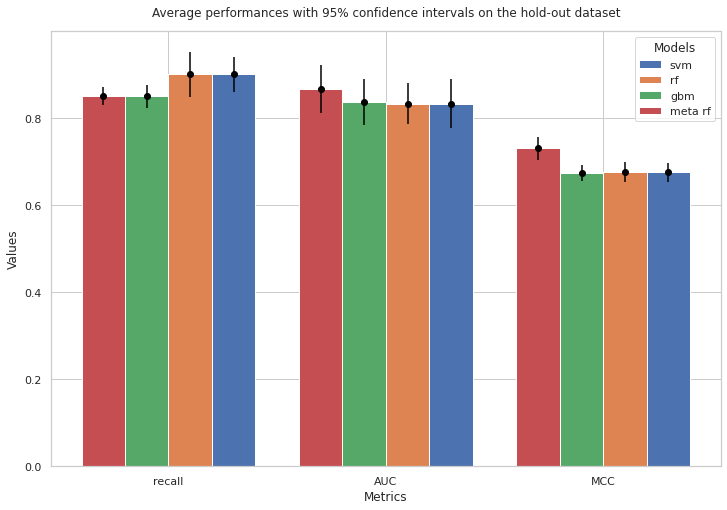

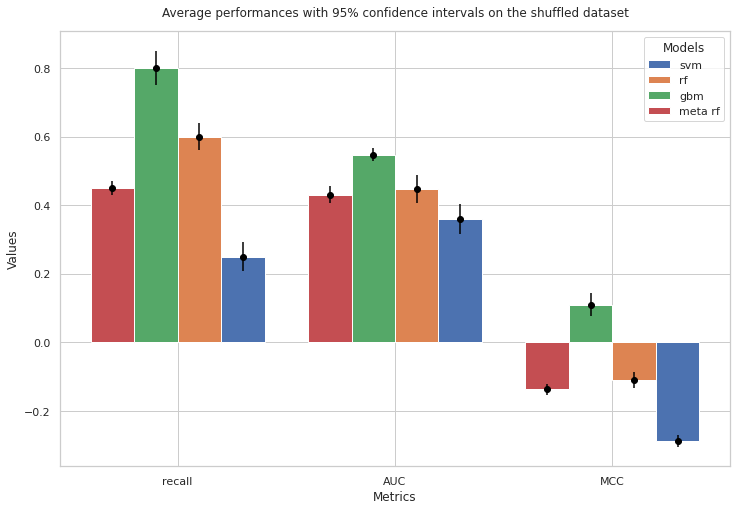

In [ ]:
# plot data in grouped manner of bar type
for dataset_type in list(performance_df['Datasets'].unique()):
  fig, ax = plt.subplots(figsize=(12, 8))
  x = np.arange(len(performance_df['Metrics'].unique()))
  bar_width = 0.2

  for model,location in zip(list(performance_df['Models'].unique()),[x + 1.5*bar_width,x+0.5*bar_width,x-0.5*bar_width,x-1.5*bar_width]):
    temp_df=performance_df[performance_df['Datasets']==dataset_type]

    ax.bar(location, temp_df.loc[temp_df['Models'] == model, 'Values'],
                width=bar_width,label=model)
    ax.errorbar(location, temp_df.loc[temp_df['Models']== model, 'Values'],
                yerr=temp_df.loc[temp_df['Models']== model, 'CI'],fmt="o", color='black')


    # Fix the x-axes.
    ax.set_xticks(x)
    ax.set_xticklabels(performance_df['Metrics'].unique())

  #Add legend
  ax.legend(title='Models',
            loc='best')

  ax.set_xlabel('Metrics')
  ax.set_ylabel('Values')
  ax.set_title('Average performances with 95% confidence intervals on the '+dataset_type+' dataset', pad=15)

  plt.show()

> * For the hold-out dataset, the recall and AUC for the 4 models are similar. Meta RF, though, has a significantly higher MCC than the other three models do. 
* For the shuffled dataset, meta RF and SVM are significancntly the worst two models. 
*  With 95% confidence, the meta RF was the most relibale model with the best performance and thus, was chosen to be the AntiPhospho model.

### Base-level RF learner feature importance
* The meta RF 'StackingClassifier' object has no attribute 'feature_importances_' so the base-level RF's feature importances are shown below

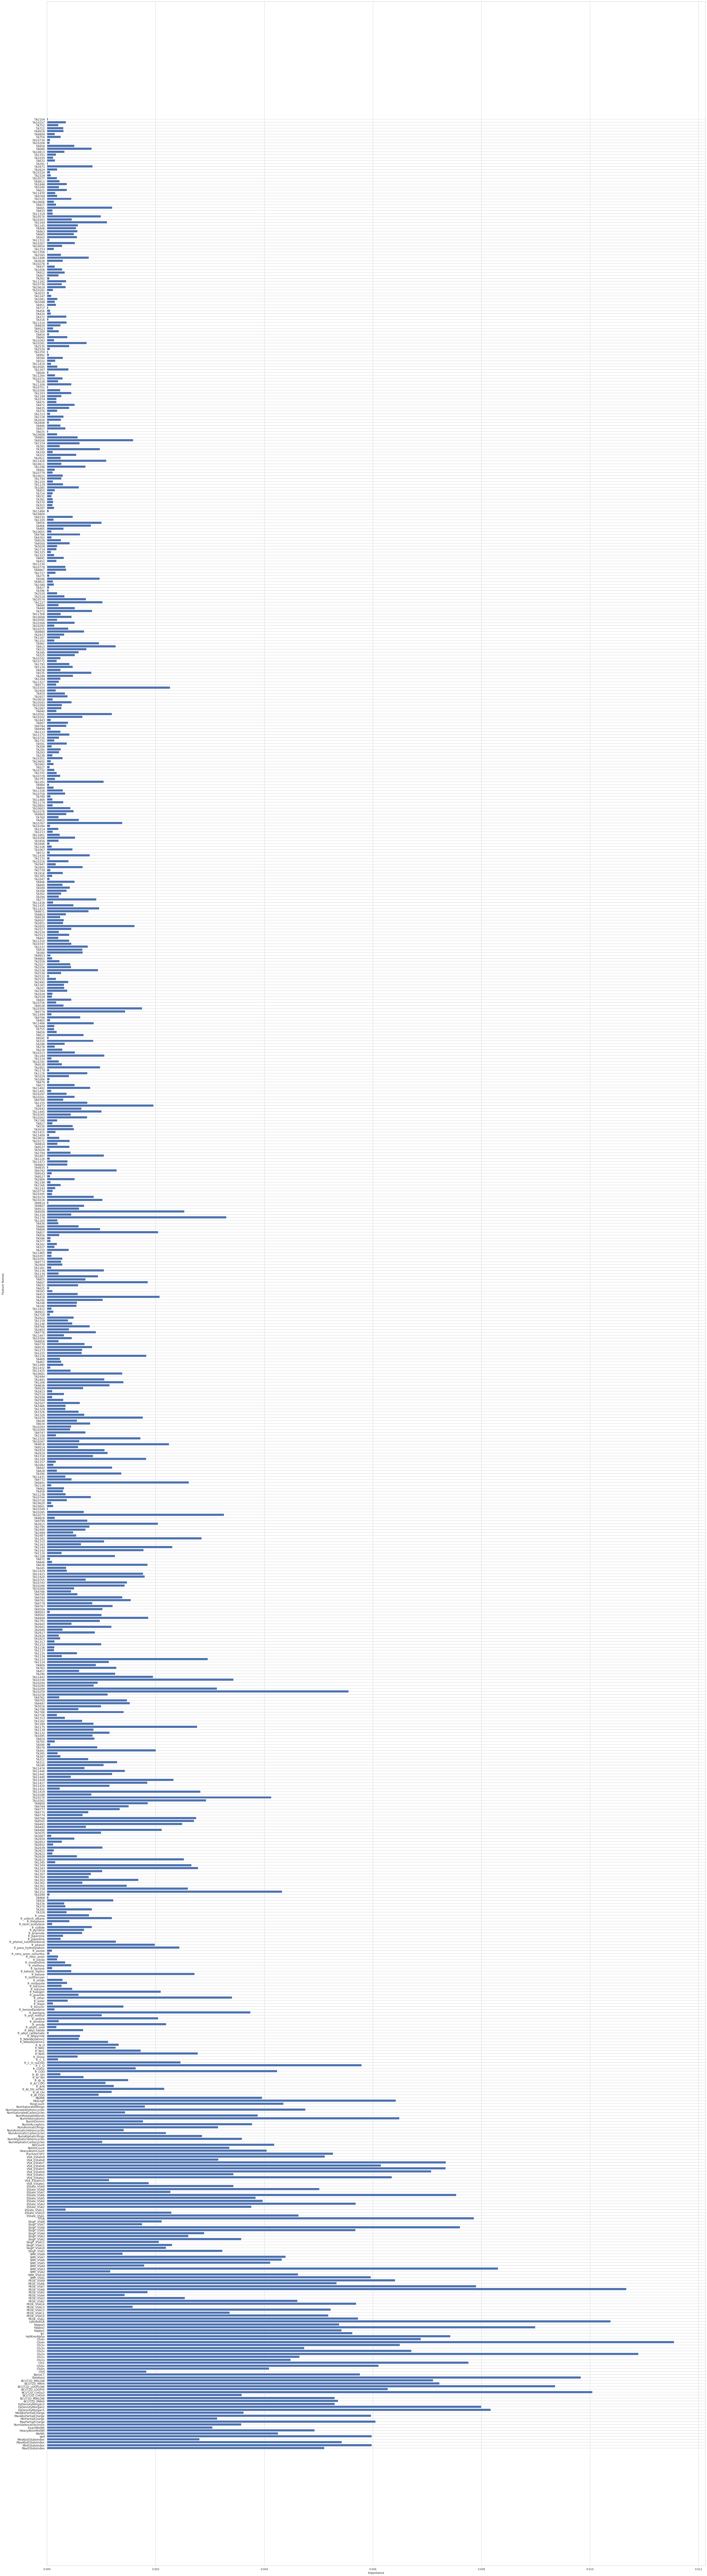

In [ ]:
simpleList = whole_descriptor_df_X.columns
importance = ppl_model_dict['rf'].feature_importances_.copy()

non_zero_index_list = [i for i, v in enumerate(importance) if v != 0]
non_zero_feature_names = [simpleList[i] for i in non_zero_index_list]
non_zero_importance = [importance[i] for i in non_zero_index_list]


fig,ax = plt.subplots(figsize=(50,200))
plt.barh(non_zero_feature_names, non_zero_importance)
ax.set_yticklabels(non_zero_feature_names, fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.show()

> The most important feature for the base-level RF is Chi4n, which is similar to Hall Kier ChiXv (valence connectivity indices), but uses nVal instead of valence. 

## 3 cherry-picking validations

Generate RDKit descriptors

In [ ]:
cherry_picking_smiles_dict={'Remdesivir':'CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4',
                            'Elacridar':'COC1=CC=CC2=C1NC3=C(C2=O)C=CC=C3C(=O)NC4=CC=C(C=C4)CCN5CCC6=CC(=C(C=C6C5)OC)OC',
                            'DLAD':'CC(C(=O)OC(C)C(=O)O)O'
                            }
                            
descriptors_list = [x[0] for x in Descriptors._descList] #This is a list of simple descriptors to be calculated
calc=MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

cherry_picking_list=[]
for molecule_name,molecule_smiles in cherry_picking_smiles_dict.items(): 
  mol = Chem.MolFromSmiles(molecule_smiles)
  individual_list=list(calc.CalcDescriptors(mol))
  individual_list.insert(0,molecule_name) #Insert the molecule name to the first position of the individual_list
  cherry_picking_list.append(individual_list)

cherry_picking_titles=[x[0] for x in Descriptors._descList]
cherry_picking_titles.insert(0,'Molecule')
cherry_picking_descriptor_df=pd.DataFrame(cherry_picking_list,columns=cherry_picking_titles)
cherry_picking_descriptor_df

,Molecule,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Remdesivir,13.901717,-4.316078,13.901717,0.096133,0.164002,602.585,567.305,602.225399,226,0,0.459060,-0.464230,0.464230,0.459060,1.261905,1.976190,2.642857,31.197367,9.924817,2.576762,-2.253665,2.469527,-2.406598,7.516875,-0.146365,1.532769,1461.825018,30.492989,23.491316,24.385743,20.068665,13.545393,15.088051,9.961007,11.654915,7.185481,8.829173,4.571220,6.073349,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Elacridar,13.345922,-0.294177,13.345922,0.145639,0.240299,563.654,530.390,563.242021,214,0,0.257296,-0.494555,0.494555,0.257296,0.833333,1.500000,2.214286,16.508131,9.980701,2.196503,-2.291655,2.330896,-2.318501,6.128561,0.102341,1.138439,1845.488716,29.216603,23.952192,23.952192,20.482228,13.968811,13.968811,10.468189,10.468189,8.020092,8.020092,5.727759,5.727759,...,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,DLAD,10.522130,-1.280741,10.522130,0.930648,0.540293,162.141,152.061,162.052823,64,0,0.344217,-0.478513,0.478513,0.344217,1.363636,1.818182,2.090909,16.569505,10.363749,2.184679,-2.087701,1.939727,-2.285494,5.790812,-0.167612,3.853318,162.355578,9.016508,6.273873,6.273873,4.947265,3.061931,3.061931,2.093326,2.093326,0.981810,0.981810,0.323110,0.323110,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Generate SA descriptors

In [ ]:
cherry_sa_df=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisCherryPickingValidation/3%20cherry%20picking%20SA.csv?raw=true')
cherry_sa_df.drop(columns=['MOLECULEID','SMILES'],inplace=True)
cherry_sa_df

,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,TA1088,TA1099,TA1101,TA1152,TA1158,TA1162,TA1301,TA1302,TA1303,TA1304,TA1307,TA1319,TA1340,TA1343,TA1344,TA1345,TA2615,TA2620,TA2621,TA2623,TA2639,TA2652,TA2653,TA2654,TA3007,TA3035,TA3036,TA9488,TA9492,TA9493,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Fuse the 2 sets of descriptors together

In [ ]:
cherry_picking_descriptor_X=pd.concat([cherry_picking_descriptor_df.drop(columns=['Molecule']), cherry_sa_df], axis=1)
cherry_picking_descriptor_X

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,13.901717,-4.316078,13.901717,0.096133,0.164002,602.585,567.305,602.225399,226,0,0.459060,-0.464230,0.464230,0.459060,1.261905,1.976190,2.642857,31.197367,9.924817,2.576762,-2.253665,2.469527,-2.406598,7.516875,-0.146365,1.532769,1461.825018,30.492989,23.491316,24.385743,20.068665,13.545393,15.088051,9.961007,11.654915,7.185481,8.829173,4.571220,6.073349,-3.57,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13.345922,-0.294177,13.345922,0.145639,0.240299,563.654,530.390,563.242021,214,0,0.257296,-0.494555,0.494555,0.257296,0.833333,1.500000,2.214286,16.508131,9.980701,2.196503,-2.291655,2.330896,-2.318501,6.128561,0.102341,1.138439,1845.488716,29.216603,23.952192,23.952192,20.482228,13.968811,13.968811,10.468189,10.468189,8.020092,8.020092,5.727759,5.727759,-4.82,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.522130,-1.280741,10.522130,0.930648,0.540293,162.141,152.061,162.052823,64,0,0.344217,-0.478513,0.478513,0.344217,1.363636,1.818182,2.090909,16.569505,10.363749,2.184679,-2.087701,1.939727,-2.285494,5.790812,-0.167612,3.853318,162.355578,9.016508,6.273873,6.273873,4.947265,3.061931,3.061931,2.093326,2.093326,0.981810,0.981810,0.323110,0.323110,-1.10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ppl_model_trained=ppl_model_dict['meta rf'].fit(descriptor_df_X,descriptor_df_y)
ppl_model_trained.predict(cherry_picking_descriptor_X)

array([0, 0, 0])

In [ ]:
display(ppl_model_trained.classes_)
cherry_results=ppl_model_trained.predict_proba(cherry_picking_descriptor_X)
pd.DataFrame(cherry_results,index=cherry_picking_smiles_dict.keys())

array([0, 1])

,0,1
Remdesivir,0.980198,0.019802
Elacridar,0.722772,0.277228
DLAD,0.831683,0.168317


> Both Remdesivir and Elacridar are known to be non-phospholipidosis-inducing in other papers. I later tested the DLAD in vitro and it is also not phospholipidosis-inducing. 
> These means that the AntiPhospho model passed the cherry-picking validation.

## Predictions on the AntiCovid's dataset 
* Expecting a decent raito of them to be positive for inducing phospholipidosis

In [ ]:
anti_virus_df=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisCherryPickingValidation/all%20271%20positives%20SA.csv?raw=true')
anti_virus_df

,SMILES,MOLECULEID,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,TA1088,TA1099,TA1101,TA1152,TA1158,TA1162,TA1301,TA1302,TA1303,TA1304,TA1307,TA1319,TA1340,TA1343,TA1344,TA1345,TA2615,TA2620,TA2621,TA2623,TA2639,TA2652,TA2653,TA2654,TA3007,TA3035,TA3036,TA9488,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,CC1=CC=C(C)C(OC2=CC=NC=C2C(=O)N2CCN(C3CC3)C3=C...,M98424983,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,FC1=CC=C(CNC2=NC=NC3=C2C=C(F)C=C3)C=C1,M9321044,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NC(=O)N1CCC(CC(=O)N2CCC(CC2)[C@H]2C3=C(CCC4=C2...,M451514,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,FC1=CC=C(C=C1)N1C=C(CCCCN2CCC3(CC2)OCC2=CC=CC=...,M204145,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,COC1=CC=C(OC)C(CN(C(C)=O)C2=CC(F)=CC=C2OC2=CC=...,M1849,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,Cl.CN(\N=C\C1=CN=C2C=CC(Br)=CN12)S(=O)(=O)C1=C...,M620781,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,CC[C@@]1(O)C(=O)OCC2=C1C=C1N(CC3=C1N=C1C=CC=CC...,M15767,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
268,CS(O)(=O)=O.CS(O)(=O)=O.NC(=N)NC1=CC=C(C=C1)C(...,M3407489,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269,C[C@H]1CN([C@H](C)CN1CC1=CC=C(F)C=C1)C(=O)C1=C...,M560765,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Generate RDKit descriptors

In [ ]:
descriptors_list = [x[0] for x in Descriptors._descList] #This is a list of simple descriptors to be calculated
calc=MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

anti_virus_list=[]
for molecule_name,molecule_smiles in zip(anti_virus_df['MOLECULEID'],anti_virus_df['SMILES']): 
  mol = Chem.MolFromSmiles(molecule_smiles)
  individual_list=list(calc.CalcDescriptors(mol))
  individual_list.insert(0,molecule_name) #Insert the molecule name to the first position of the individual_list
  anti_virus_list.append(individual_list)

anti_virus_titles=[x[0] for x in Descriptors._descList]
anti_virus_titles.insert(0,'MoleculeID')
anti_virus_descriptor_df=pd.DataFrame(anti_virus_list,columns=anti_virus_titles)
anti_virus_descriptor_df

,MoleculeID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,M98424983,13.604922,-0.077497,13.604922,0.077497,0.610849,399.494,374.294,399.194677,152,0,0.263268,-0.456127,0.456127,0.263268,1.000000,1.800000,2.600000,16.481967,10.100873,2.356650,-2.376905,2.405220,-2.446476,6.094600,0.098364,1.484678e+00,1107.052806,20.664561,17.337417,17.337417,14.614194,10.482809,10.482809,8.112921,8.112921,5.854306,5.854306,4.072778,4.072778,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,M9321044,13.299272,-0.335989,13.299272,0.274716,0.791648,271.270,260.182,271.092104,100,0,0.137161,-0.365378,0.365378,0.137161,0.900000,1.650000,2.450000,19.143515,10.172719,2.044425,-2.080138,2.201959,-2.023550,5.882132,0.626743,1.868255e+00,741.694733,13.949383,10.476265,10.476265,9.720347,6.108084,6.108084,4.363766,4.363766,2.970590,2.970590,1.957767,1.957767,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M451514,13.126497,-0.361792,13.126497,0.173723,0.454301,638.832,607.584,636.050228,192,0,0.314278,-0.351491,0.351491,0.314278,0.972222,1.638889,2.333333,79.919762,9.761099,2.364038,-2.378534,2.458527,-2.437180,9.104638,-0.133521,1.305605e+00,1160.702924,25.396612,20.189008,24.116930,17.295734,12.741112,14.705073,10.326984,12.533432,8.170563,9.478538,6.245971,7.745181,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,M204145,13.412116,-0.201138,13.412116,0.046354,0.304938,454.589,423.341,454.242042,174,0,0.122860,-0.365494,0.365494,0.122860,0.852941,1.617647,2.470588,19.142146,9.835550,2.415988,-2.389393,2.435180,-2.423224,5.852155,-0.078797,1.061960e+00,1284.916663,22.959608,19.550154,19.550154,16.717077,12.514834,12.514834,9.756766,9.756766,7.745655,7.745655,5.851383,5.851383,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,M1849,14.074438,-0.468270,14.074438,0.157053,0.552502,395.430,373.254,395.153286,150,0,0.223787,-0.496752,0.496752,0.223787,0.896552,1.620690,2.275862,19.142148,10.124684,2.203391,-2.247412,2.353196,-2.281925,5.928723,-0.116257,2.016068e+00,991.422937,20.802754,16.516131,16.516131,14.011570,9.029846,9.029846,6.310102,6.310102,4.378932,4.378932,2.945231,2.945231,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,M620781,12.764686,-4.048290,12.764686,0.000000,0.310477,488.751,473.631,486.971665,148,0,0.278761,-0.297532,0.297532,0.278761,1.321429,2.035714,2.714286,79.918731,10.206596,2.240070,-2.146697,2.240057,-2.225978,9.102989,-0.384628,2.803330e-06,1178.991373,19.767220,14.682324,17.901314,12.696414,7.605143,9.838204,5.649352,8.483435,3.859057,6.113761,2.394086,3.931527,...,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,

Generate SA descriptors

In [ ]:
anti_virus_sa_df=anti_virus_df.drop(columns=['MOLECULEID','SMILES'])
anti_virus_sa_df

,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,TA1088,TA1099,TA1101,TA1152,TA1158,TA1162,TA1301,TA1302,TA1303,TA1304,TA1307,TA1319,TA1340,TA1343,TA1344,TA1345,TA2615,TA2620,TA2621,TA2623,TA2639,TA2652,TA2653,TA2654,TA3007,TA3035,TA3036,TA9488,TA9492,TA9493,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
268,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Fuse the 2 sets of descriptors together

In [ ]:
anti_virus_descriptor_X=pd.concat([anti_virus_descriptor_df.drop(columns=['MoleculeID']), anti_virus_sa_df], axis=1)
anti_virus_descriptor_X

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,13.604922,-0.077497,13.604922,0.077497,0.610849,399.494,374.294,399.194677,152,0,0.263268,-0.456127,0.456127,0.263268,1.000000,1.800000,2.600000,16.481967,10.100873,2.356650,-2.376905,2.405220,-2.446476,6.094600,0.098364,1.484678e+00,1107.052806,20.664561,17.337417,17.337417,14.614194,10.482809,10.482809,8.112921,8.112921,5.854306,5.854306,4.072778,4.072778,-3.34,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,13.299272,-0.335989,13.299272,0.274716,0.791648,271.270,260.182,271.092104,100,0,0.137161,-0.365378,0.365378,0.137161,0.900000,1.650000,2.450000,19.143515,10.172719,2.044425,-2.080138,2.201959,-2.023550,5.882132,0.626743,1.868255e+00,741.694733,13.949383,10.476265,10.476265,9.720347,6.108084,6.108084,4.363766,4.363766,2.970590,2.970590,1.957767,1.957767,-2.56,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13.126497,-0.361792,13.126497,0.173723,0.454301,638.832,607.584,636.050228,192,0,0.314278,-0.351491,0.351491,0.314278,0.972222,1.638889,2.333333,79.919762,9.761099,2.364038,-2.378534,2.458527,-2.437180,9.104638,-0.133521,1.305605e+00,1160.702924,25.396612,20.189008,24.116930,17.295734,12.741112,14.705073,10.326984,12.533432,8.170563,9.478538,6.245971,7.745181,-1.64,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.412116,-0.201138,13.412116,0.046354,0.304938,454.589,423.341,454.242042,174,0,0.122860,-0.365494,0.365494,0.122860,0.852941,1.617647,2.470588,19.142146,9.835550,2.415988,-2.389393,2.435180,-2.423224,5.852155,-0.078797,1.061960e+00,1284.916663,22.959608,19.550154,19.550154,16.717077,12.514834,12.514834,9.756766,9.756766,7.745655,7.745655,5.851383,5.851383,-2.95,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.074438,-0.468270,14.074438,0.157053,0.552502,395.430,373.254,395.153286,150,0,0.223787,-0.496752,0.496752,0.223787,0.896552,1.620690,2.275862,19.142148,10.124684,2.203391,-2.247412,2.353196,-2.281925,5.928723,-0.116257,2.016068e+00,991.422937,20.802754,16.516131,16.516131,14.011570,9.029846,9.029846,6.310102,6.310102,4.378932,4.378932,2.945231,2.945231,-3.54,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,12.764686,-4.048290,12.764686,0.000000,0.310477,488.751,473.631,486.971665,148,0,0.278761,-0.297532,0.297532,0.278761,1.321429,2.035714,2.714286,79.918731,10.206596,2.240070,-2.146697,2.240057,-2.225978,9.102989,-0.384628,2.803330e-06,1178.991373,19.767220,14.682324,17.901314,12.696414,7.605143,9.838204,5.649352,8.483435,3.859057,6.113761,2.394086,3.931527,-2.50,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,13.010453,-1.789747,13.010453,0.109782,0.532764,348.358,332.230,348.111007,130,0,0.342676,-0.458198,0.458198,0.342676,1.269231,2.076923,2.884615,16.551302,9.857667,2.448553,-2.312575,2.379539,-2.439179,5.

In [ ]:
print('Before cleaning, you have', len(anti_virus_descriptor_X),'datapoints')
anti_virus_descriptor_X=anti_virus_descriptor_X.dropna() #By default, dropna(axis=0) which means drop rows which contain missing values
print('After cleaning, you have', len(anti_virus_descriptor_X),'datapoints')
anti_virus_descriptor_X

Before cleaning, you have 271 datapoints
After cleaning, you have 270 datapoints


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,13.604922,-0.077497,13.604922,0.077497,0.610849,399.494,374.294,399.194677,152,0,0.263268,-0.456127,0.456127,0.263268,1.000000,1.800000,2.600000,16.481967,10.100873,2.356650,-2.376905,2.405220,-2.446476,6.094600,0.098364,1.484678e+00,1107.052806,20.664561,17.337417,17.337417,14.614194,10.482809,10.482809,8.112921,8.112921,5.854306,5.854306,4.072778,4.072778,-3.34,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,13.299272,-0.335989,13.299272,0.274716,0.791648,271.270,260.182,271.092104,100,0,0.137161,-0.365378,0.365378,0.137161,0.900000,1.650000,2.450000,19.143515,10.172719,2.044425,-2.080138,2.201959,-2.023550,5.882132,0.626743,1.868255e+00,741.694733,13.949383,10.476265,10.476265,9.720347,6.108084,6.108084,4.363766,4.363766,2.970590,2.970590,1.957767,1.957767,-2.56,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13.126497,-0.361792,13.126497,0.173723,0.454301,638.832,607.584,636.050228,192,0,0.314278,-0.351491,0.351491,0.314278,0.972222,1.638889,2.333333,79.919762,9.761099,2.364038,-2.378534,2.458527,-2.437180,9.104638,-0.133521,1.305605e+00,1160.702924,25.396612,20.189008,24.116930,17.295734,12.741112,14.705073,10.326984,12.533432,8.170563,9.478538,6.245971,7.745181,-1.64,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.412116,-0.201138,13.412116,0.046354,0.304938,454.589,423.341,454.242042,174,0,0.122860,-0.365494,0.365494,0.122860,0.852941,1.617647,2.470588,19.142146,9.835550,2.415988,-2.389393,2.435180,-2.423224,5.852155,-0.078797,1.061960e+00,1284.916663,22.959608,19.550154,19.550154,16.717077,12.514834,12.514834,9.756766,9.756766,7.745655,7.745655,5.851383,5.851383,-2.95,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.074438,-0.468270,14.074438,0.157053,0.552502,395.430,373.254,395.153286,150,0,0.223787,-0.496752,0.496752,0.223787,0.896552,1.620690,2.275862,19.142148,10.124684,2.203391,-2.247412,2.353196,-2.281925,5.928723,-0.116257,2.016068e+00,991.422937,20.802754,16.516131,16.516131,14.011570,9.029846,9.029846,6.310102,6.310102,4.378932,4.378932,2.945231,2.945231,-3.54,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,12.764686,-4.048290,12.764686,0.000000,0.310477,488.751,473.631,486.971665,148,0,0.278761,-0.297532,0.297532,0.278761,1.321429,2.035714,2.714286,79.918731,10.206596,2.240070,-2.146697,2.240057,-2.225978,9.102989,-0.384628,2.803330e-06,1178.991373,19.767220,14.682324,17.901314,12.696414,7.605143,9.838204,5.649352,8.483435,3.859057,6.113761,2.394086,3.931527,-2.50,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,13.010453,-1.789747,13.010453,0.109782,0.532764,348.358,332.230,348.111007,130,0,0.342676,-0.458198,0.458198,0.342676,1.269231,2.076923,2.884615,16.551302,9.857667,2.448553,-2.312575,2.379539,-2.439179,5.

In [ ]:
ppl_model_trained=ppl_model_dict['meta rf'].fit(descriptor_df_X,descriptor_df_y)
ppl_result_array=ppl_model_trained.predict(anti_virus_descriptor_X)
unique, counts = np.unique(ppl_result_array, return_counts=True)
display(pd.DataFrame(np.asarray((unique, counts)).T,columns=['Classes','Counts']))

,Classes,Counts
0,0,178
1,1,92


> 34% of the active anti-virus molecules in the AntiCovid's dataset are predicted to be phospholipidosis-inducing, which agrees with the major points raised up by this Science paper: [Drug-induced phospholipidosis confounds drug repurposing for SARS-CoV-2](https://www.science.org/doi/10.1126/science.abi4708)

> However, not all of the active drugs are predicted to be phospholipidosis-inducing, which means a bigger portion of them (specifically, 66%) are really virus-specific active. This is a good sign. 

## Predictions on the AntiCovid's predictions
* Simiar to the predictions above, but performed on the molecules that the AntiCovid model predicted to be effective for anti-SARS-CoV-2.

In [ ]:
anti_covid_positives_df=pd.read_csv('https://raw.githubusercontent.com/junqilu/AntiSARSCoV2Prediction/main/PhospholipidosisCherryPickingValidation/AntiCovid%20predicted%20positives.csv')
anti_covid_positives_df

,SMILES,MOLECULEID,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,TA1088,TA1099,TA1101,TA1152,TA1158,TA1162,TA1301,TA1302,TA1303,TA1304,TA1307,TA1319,TA1340,TA1343,TA1344,TA1345,TA2615,TA2620,TA2621,TA2623,TA2639,TA2652,TA2653,TA2654,TA3007,TA3035,TA3036,TA9488,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,CCN(CC)CCCCNC1=NC=C2C=C(C(NC(=O)NC(C)(C)C)=NC2...,M189491,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,CC(CC1=CC=C(O)C(O)=C1)C(C)CC1=CC=C(O)C(O)=C1,M3719,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,COC1=C2NC(=CC2=CC=C1)C1=C2N(N=CN=C2N)C(=N1)[C@...,M14391345,1.0,1.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,IC1=CC=C(NC(=N)NC2C3CC4CC(C3)CC2C4)C=C1,M653433,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4,NC(=O)N1CCC(CC(=O)N2CCC(CC2)[C@H]2C3=C(CCC4=C2...,M451514,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
5,CCC(=O)N1CCN(CC1)C1=CC=C(C=C1C(F)(F)F)N1C(=O)C...,M3663334,1.0,1.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
6,C[C@H]1CN([C@H](C)CN1CC1=CC=C(F)C=C1)C(=O)C1=C...,M560765,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
7,CCCCCCCCCCCCCCCCCC[S+](CCC)C1=CC=CC=C1C(=O)OCC,M65211554,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
8,[H]C1=C([H])C(=C([H])C([H])=C1OC([H])([H])C([H...,M83431085,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
9,FC(F)(F)C1=CC=C(C=CC2=NC(COC3=CC=C(CCCCN4C=CN=...,M6633944,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,1.0,0,0


Generate RDKit descriptors

In [ ]:
descriptors_list = [x[0] for x in Descriptors._descList] #This is a list of simple descriptors to be calculated
calc=MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

anti_virus_list=[]
for molecule_name,molecule_smiles in zip(anti_covid_positives_df['MOLECULEID'],anti_covid_positives_df['SMILES']): 
  mol = Chem.MolFromSmiles(molecule_smiles)
  individual_list=list(calc.CalcDescriptors(mol))
  individual_list.insert(0,molecule_name) #Insert the molecule name to the first position of the individual_list
  anti_virus_list.append(individual_list)

anti_virus_titles=[x[0] for x in Descriptors._descList]
anti_virus_titles.insert(0,'MoleculeID')
anti_virus_descriptor_df=pd.DataFrame(anti_virus_list,columns=anti_virus_titles)
anti_virus_descriptor_df

,MoleculeID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,M189491,12.702031,-0.422936,12.702031,0.308447,0.259840,532.520,497.240,531.228014,194,0,0.320323,-0.354162,0.354162,0.320323,1.055556,1.750000,2.388889,35.496837,10.048458,2.198499,-2.213173,2.388419,-2.428387,6.391438,0.243480,1.875299e+00,1172.611630,26.294318,21.582424,23.094282,17.106705,12.284814,13.040743,9.577530,10.391930,5.599810,6.229751,3.769474,4.370519,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1
1,M3719,9.541867,-0.107389,9.541867,0.096472,0.636536,302.370,280.194,302.151809,118,0,0.157162,-0.504260,0.504260,0.157162,0.636364,1.000000,1.318182,16.306385,9.851100,2.149623,-2.202461,2.296775,-2.132396,5.411759,0.376699,2.000803e+00,594.030570,16.275656,12.821870,12.821870,10.363081,7.382132,7.382132,6.008949,6.008949,4.166410,4.166410,2.537905,2.537905,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M14391345,11.308868,-0.721567,11.308868,0.120430,0.473974,406.446,384.270,406.175339,154,0,0.305988,-0.494557,0.494557,0.305988,1.300000,2.100000,2.833333,16.466043,9.815159,2.306596,-2.243594,2.386726,-2.214071,5.933168,-0.142404,1.626998e+00,1252.584250,20.827698,16.499794,16.499794,14.562882,9.944921,9.944921,7.718597,7.718597,6.020586,6.020586,4.453870,4.453870,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M653433,8.232652,0.466372,8.232652,0.466372,0.402079,395.288,373.112,395.085846,112,0,0.192656,-0.353009,0.353009,0.192656,0.952381,1.523810,2.095238,126.912704,9.539546,2.478379,-2.541678,2.531593,-2.562160,14.111917,-0.006946,1.392525e+00,511.471132,14.396977,12.109651,14.267149,10.169836,8.048174,9.126923,7.107735,8.353368,5.651297,6.370463,5.041162,5.400746,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M451514,13.126497,-0.361792,13.126497,0.173723,0.454301,638.832,607.584,636.050228,192,0,0.314278,-0.351491,0.351491,0.314278,0.972222,1.638889,2.333333,79.919762,9.761099,2.364038,-2.378534,2.458527,-2.437180,9.104638,-0.133521,1.305605e+00,1160.702924,25.396612,20.189008,24.116930,17.295734,12.741112,14.705073,10.326984,12.533432,8.170563,9.478538,6.245971,7.745181,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
5,M3663334,14.583206,-4.670850,14.583206,0.015624,0.205585,607.636,579.412,607.219510,226,0,0.417974,-0.367488,0.417974,0.367488,0.800000,1.577778,2.355556,19.413203,10.013101,2.361833,-2.368778,2.389665,-2.486259,6.052316,-0.137083,1.371594e+00,2168.067263,31.293953,24.382246,24.382246,21.706860,14.751214,14.751214,11.138350,11.138350,8.460357,8.460357,6.162422,6.162422,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0
6,M560765,13.667141,-0.636371,13.667141,0.073414,0.383025,513.013,482.773,512.199047,190,0,0.294025,-0.349737,0.349737,0.294025,1.027778,1.694444,2.333333,35.495692,10.021055,2.335735,-2.439520,2.304250,-2.571959,6.447479,-0.123581,1.602160e+00,1335.032443,26.308672,21.087001,21.842930,16

Generate SA descriptors

In [ ]:
anti_virus_sa_df=anti_covid_positives_df.drop(columns=['MOLECULEID','SMILES'])
anti_virus_sa_df

,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,TA1088,TA1099,TA1101,TA1152,TA1158,TA1162,TA1301,TA1302,TA1303,TA1304,TA1307,TA1319,TA1340,TA1343,TA1344,TA1345,TA2615,TA2620,TA2621,TA2623,TA2639,TA2652,TA2653,TA2654,TA3007,TA3035,TA3036,TA9488,TA9492,TA9493,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,1.0,1.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,1.0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
5,1.0,1.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
6,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
7,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
8,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
9,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,1.0,1.0,1.0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,1.0,0,0


Fuse the 2 sets of descriptors together

In [ ]:
anti_virus_descriptor_X=pd.concat([anti_virus_descriptor_df.drop(columns=['MoleculeID']), anti_virus_sa_df], axis=1)
anti_virus_descriptor_X

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,12.702031,-0.422936,12.702031,0.308447,0.259840,532.520,497.240,531.228014,194,0,0.320323,-0.354162,0.354162,0.320323,1.055556,1.750000,2.388889,35.496837,10.048458,2.198499,-2.213173,2.388419,-2.428387,6.391438,0.243480,1.875299e+00,1172.611630,26.294318,21.582424,23.094282,17.106705,12.284814,13.040743,9.577530,10.391930,5.599810,6.229751,3.769474,4.370519,-2.68,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,9.541867,-0.107389,9.541867,0.096472,0.636536,302.370,280.194,302.151809,118,0,0.157162,-0.504260,0.504260,0.157162,0.636364,1.000000,1.318182,16.306385,9.851100,2.149623,-2.202461,2.296775,-2.132396,5.411759,0.376699,2.000803e+00,594.030570,16.275656,12.821870,12.821870,10.363081,7.382132,7.382132,6.008949,6.008949,4.166410,4.166410,2.537905,2.537905,-2.36,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,11.308868,-0.721567,11.308868,0.120430,0.473974,406.446,384.270,406.175339,154,0,0.305988,-0.494557,0.494557,0.305988,1.300000,2.100000,2.833333,16.466043,9.815159,2.306596,-2.243594,2.386726,-2.214071,5.933168,-0.142404,1.626998e+00,1252.584250,20.827698,16.499794,16.499794,14.562882,9.944921,9.944921,7.718597,7.718597,6.020586,6.020586,4.453870,4.453870,-3.62,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,8.232652,0.466372,8.232652,0.466372,0.402079,395.288,373.112,395.085846,112,0,0.192656,-0.353009,0.353009,0.192656,0.952381,1.523810,2.095238,126.912704,9.539546,2.478379,-2.541678,2.531593,-2.562160,14.111917,-0.006946,1.392525e+00,511.471132,14.396977,12.109651,14.267149,10.169836,8.048174,9.126923,7.107735,8.353368,5.651297,6.370463,5.041162,5.400746,-0.78,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4,13.126497,-0.361792,13.126497,0.173723,0.454301,638.832,607.584,636.050228,192,0,0.314278,-0.351491,0.351491,0.314278,0.972222,1.638889,2.333333,79.919762,9.761099,2.364038,-2.378534,2.458527,-2.437180,9.104638,-0.133521,1.305605e+00,1160.702924,25.396612,20.189008,24.116930,17.295734,12.741112,14.705073,10.326984,12.533432,8.170563,9.478538,6.245971,7.745181,-1.64,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
5,14.583206,-4.670850,14.583206,0.015624,0.205585,607.636,579.412,607.219510,226,0,0.417974,-0.367488,0.417974,0.367488,0.800000,1.577778,2.355556,19.413203,10.013101,2.361833,-2.368778,2.389665,-2.486259,6.052316,-0.137083,1.371594e+00,2168.067263,31.293953,24.382246,24.382246,21.706860,14.751214,14.751214,11.138350,11.138350,8.460357,8.460357,6.162422,6.162422,-5.25,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
6,13.667141,-0.636371,13.667141,0.073414,0.383025,513.013,482.773,512.199047,190,0,0.294025,-0.349737,0.349737,0.294025,1.027778,1.694444,2.333333,35.495692,10.021055,2.335735,-2.439520,2.304250,-2.571959,6.447479,-0.123581,1.602160e+00,1335.032443,26.308672,21.087001,21.842930,16.972142,11.815571,12.193536,9.743053,10.150254,6.828581,7.141290,4.746628,4.985365,-3.23,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
print('Before cleaning, you have', len(anti_virus_descriptor_X),'datapoints')
anti_virus_descriptor_X=anti_virus_descriptor_X.dropna() #By default, dropna(axis=0) which means drop rows which contain missing values
print('After cleaning, you have', len(anti_virus_descriptor_X),'datapoints')
anti_virus_descriptor_X

Before cleaning, you have 54 datapoints
After cleaning, you have 54 datapoints


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,...,TA2671,TA10264,TA1125,TA2449,TA2450,TA2451,TA2452,TA237,TA291,TA369,TA633,TA841,TA925,TA1035,TA1069,TA1351,TA1906,TA3030,TA10592,TA10806,TA10813,TA686,TA858,TA832,TA10208,TA10734,TA11170,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,12.702031,-0.422936,12.702031,0.308447,0.259840,532.520,497.240,531.228014,194,0,0.320323,-0.354162,0.354162,0.320323,1.055556,1.750000,2.388889,35.496837,10.048458,2.198499,-2.213173,2.388419,-2.428387,6.391438,0.243480,1.875299e+00,1172.611630,26.294318,21.582424,23.094282,17.106705,12.284814,13.040743,9.577530,10.391930,5.599810,6.229751,3.769474,4.370519,-2.68,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
1,9.541867,-0.107389,9.541867,0.096472,0.636536,302.370,280.194,302.151809,118,0,0.157162,-0.504260,0.504260,0.157162,0.636364,1.000000,1.318182,16.306385,9.851100,2.149623,-2.202461,2.296775,-2.132396,5.411759,0.376699,2.000803e+00,594.030570,16.275656,12.821870,12.821870,10.363081,7.382132,7.382132,6.008949,6.008949,4.166410,4.166410,2.537905,2.537905,-2.36,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
2,11.308868,-0.721567,11.308868,0.120430,0.473974,406.446,384.270,406.175339,154,0,0.305988,-0.494557,0.494557,0.305988,1.300000,2.100000,2.833333,16.466043,9.815159,2.306596,-2.243594,2.386726,-2.214071,5.933168,-0.142404,1.626998e+00,1252.584250,20.827698,16.499794,16.499794,14.562882,9.944921,9.944921,7.718597,7.718597,6.020586,6.020586,4.453870,4.453870,-3.62,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
3,8.232652,0.466372,8.232652,0.466372,0.402079,395.288,373.112,395.085846,112,0,0.192656,-0.353009,0.353009,0.192656,0.952381,1.523810,2.095238,126.912704,9.539546,2.478379,-2.541678,2.531593,-2.562160,14.111917,-0.006946,1.392525e+00,511.471132,14.396977,12.109651,14.267149,10.169836,8.048174,9.126923,7.107735,8.353368,5.651297,6.370463,5.041162,5.400746,-0.78,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
4,13.126497,-0.361792,13.126497,0.173723,0.454301,638.832,607.584,636.050228,192,0,0.314278,-0.351491,0.351491,0.314278,0.972222,1.638889,2.333333,79.919762,9.761099,2.364038,-2.378534,2.458527,-2.437180,9.104638,-0.133521,1.305605e+00,1160.702924,25.396612,20.189008,24.116930,17.295734,12.741112,14.705073,10.326984,12.533432,8.170563,9.478538,6.245971,7.745181,-1.64,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
5,14.583206,-4.670850,14.583206,0.015624,0.205585,607.636,579.412,607.219510,226,0,0.417974,-0.367488,0.417974,0.367488,0.800000,1.577778,2.355556,19.413203,10.013101,2.361833,-2.368778,2.389665,-2.486259,6.052316,-0.137083,1.371594e+00,2168.067263,31.293953,24.382246,24.382246,21.706860,14.751214,14.751214,11.138350,11.138350,8.460357,8.460357,6.162422,6.162422,-5.25,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0,0.0,0,0.0,0,0,0.0,0,0
6,13.667141,-0.636371,13.667141,0.073414,0.383025,513.013,482.773,512.199047,190,0,0.294025,-0.349737,0.349737,0.294025,1.027778,1.694444,2.333333,35.495692,10.021055,2.335735,-2.439520,2.304250,-2.571959,6.447479,-0.123581,1.602160e+00,1335.032443,26.308672,21.087001,21.842930,16.972142,11.815571,12.193536,9.743053,10.150254,6.828581,7.141290,4.746628,4.985365,-3.23,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
ppl_model_trained=ppl_model_dict['meta rf'].fit(descriptor_df_X,descriptor_df_y)
ppl_result_array=ppl_model_trained.predict(anti_virus_descriptor_X)
unique, counts = np.unique(ppl_result_array, return_counts=True)
display(pd.DataFrame(np.asarray((unique, counts)).T,columns=['Classes','Counts']))

,Classes,Counts
0,0,34
1,1,20


> 37% of the AntiCovid's predicted active anti-virus molecules are predicted by the AntiPhospho to be phospholipidosis-inducing. This means although phospholipidosis is definitely a confounding factor here, the AntiCovid model did not predict whether a molecule is active by only learning whether the molecule is phospholipidosis-inducing. 

> Also, among the AntiCovid's positive predictions, 63% of them are non-phospholipidosis-inducing. This ratio is about the same as the ratio for active non-phospholipidosis-inducing molecules in the original dataset, which is 66%.

# Discussion & conclusions



## AntiCovid model 
>* The AntiCovid model performed much better on the subsampled dataset compared to the overall dataset. This makes sense because there was a very large imbalance problem that we were facing when training models. Even when reweighting the loss between the classes to tell the model to focus more on predicting the positive classes, the recall was much lower than we were hoping for. Upon creating a balanced dataset using a k-medioids strategy that allowed us to obtain much better overall results. 
* The most important features for the final random forest model appear to be BertzCT ("a topological index meant to quantify complexity of molecules") and MolMR, which is the relative formula mass of a substance as defined by Wildman-Crippen. 
* The model did not generalize as well to the overall dataset as it predicted a large proportion of the negatives to be COVID-19 inhibitors. However, this can be explained since the subsampled dataset is very small compared to the overall dataset and has the inhibitors in a higher proportion than the overall dataset. This could cause the models to generalize poorly. 
* If we were to deploy this model in the real world, we should gather a larger dataset with inhibitors to be confident in our models selection. Since the hold-out testing set performed well, we decided to test our model on additional molecules that we handpicked including remdesivir and ibuprofen. The results obtained by running these models were exactly as expected from what we know experimentally about the compounds. Interestingly, remdesivir is a protide or prodrug and its active form is very different than the molecular form that was input into our model. It could be that the model was robust enough to predict this transformation to an active compound, but in any case, it should be a further point of study.

## AntiPhospho model 
>* With a simple correction on the imbalanced classes by assigning weights, the AntiPhospho model performed very well on the validation sets and the hold-out test set. The great performance was further verified by a dramatic drop in recall, AUC, and MCC when the features are shuffled. 
* The most important feature for the base-level RF is Chi4n, which is similar to Hall Kier ChiXv (valence connectivity indices), but uses nVal instead of valence. Several SA also made into the top several most important features for the model. 
* We verified the performance even further by a three-point cherry-picking validation and asking AntiPhospho to predict on the dataset that was used to train AntiCovid. As expected, a decent amount of the positives (34%) in the original anti-COVID dataset were predicted to be phospholipidosis-inducing. The same trend also occurred when the AntiPhospho predicted on AntiCovid's predicted positives, which gave a 37% of predicted positives. However, the fact that not all of the active molecules are predicted to be phospholipidosis-inducing means that most of the molecules still have the potential to be developed into drugs against COVID. This also means that our AntiCovid model was not just predicting the tendency to induce phospholipidosis, but also, or mostly, learning from the anti-virus nature embedded in those positives' chemical structures.  

> In conclusion, by combining our 2 models, AntiCovid and AntiPhospho, our project is able to predict molecules that tend to be active against SARS-CoV-2 without inducing phospholipidosis. The 2 model's great performances were judged by several machine learning metrics. Our models have been trained and tested by a 10× cross-validation, hold-out testing set, and adversarial control by shuffling. This project successfully indicated the huge potentials in developing more small-molecule drugs to treat COVID-19 with further research and study.

# External tools, data sources, and references 
* Open Babel: http://www.cheminfo.org/Chemistry/Cheminformatics/FormatConverter/index.html 
  * Convert different file formats for chemicals' structures
* ToxAlerts: A Web Server of Structural Alerts http://ochem.eu/alerts 
  * Registered users work better 
  * This provides part of the phospholipidosis descriptors (Structural Alerts for potential toxicology in vivo)
* Ensemble learning 
  * A Gentle Introduction to Ensemble Learning Algorithms: https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/ 
  * Advanced Ensemble Learning technique – Stacking and its Variants: https://www.analyticsvidhya.com/blog/2021/03/advanced-ensemble-learning-technique-stacking-and-its-variants/

